In [1]:
import gzip
import json
import pickle
import os
from loguru import logger

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine
import geopandas as gpd

import numpy as np
import pandas as pd

from ppgmne_prf.config.paths import PATH_DATA_SOLVER_DETAILS, PATH_DATA_SOLVER_RESULTS, PATH_DATA_IBGE_UF, PATH_DATA_CACHE
from ppgmne_prf.utils import get_distance_matrix
from ppgmne_prf.load_data import load_data
from ppgmne_prf.preprocess import preprocess_accidents, preprocess, preprocess_stations
from ppgmne_prf.utils import clean_string

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.rcParams['figure.figsize'] = [15, 8]

sns.set_palette('deep')
PALETTE = sns.color_palette()

MAP_COLOR = '#d1cab2'
SHAPE = gpd.read_file(PATH_DATA_IBGE_UF / 'PR_Municipios_2019.shp')

In [2]:
# Funções úteis:

def calc_diff(df):
    df_out = df.copy()
    df_out['obj_function_abs_diff'] = abs(df_out['obj_function'].diff().fillna(0))
    df_out['obj_function_abs_pct_change'] = abs(df_out['obj_function'].pct_change().fillna(0))*100
    df_out['obj_function_abs_pct_change'] = np.where(
        df_out['obj_function_abs_pct_change'] == 0, 
        np.nan, 
        df_out['obj_function_abs_pct_change']
    )
    return df_out


def get_df_results(df_results, p=None, q=None):
    if p is None:
        df_out = df_results[(df_results['q'] == q)].copy()
    if q is None:
        df_out = df_results[(df_results['p'] == p)].copy()
    df_out = calc_diff(df_out)
    return df_out

def get_solution_details(q, p):
    model_name = f'model_p{p}_q{q}_details'
    with gzip.open(PATH_DATA_SOLVER_DETAILS / f"{model_name}.gz", "rb") as f:
            df_out = pickle.load(f)
    return df_out


def preproccess_muns(df_muns):
    cols = ['municipio', 'microrregiao', 'mesorregiao', 'regiao_imediata']
    cols_en = ['municipality', 'microregion', 'mesoregion', 'immediate_region', 'mun_name_orig']
    df_out = df_muns[cols].copy()
    df_out['mun_name_orig'] = df_out['municipio']

    for col in cols:
        df_out = clean_string(df=df_out, target=col, mode='upper')

    df_out.columns = cols_en
    return df_out


def get_all_results():
    output_dict = None

    for file in os.listdir(PATH_DATA_SOLVER_RESULTS):
        if file.split(".")[-1] == "json":
            with open(PATH_DATA_SOLVER_RESULTS / file) as file:
                dict_result = json.load(file)
            if output_dict is None:
                output_dict = dict_result
                for key in dict_result:
                    output_dict[key] = [dict_result[key]]
            else:
                for key in dict_result:
                    output_dict[key].append(dict_result[key])

    df_out = pd.DataFrame(output_dict)
    df_out = df_out.sort_values(['p', 'q']).reset_index(drop=True)
    return df_out


def plot_fo(
    df_plot,
    x_param,
    xtick_min=0,
    xtick_max=80,
    xtick_multiple=2,
    p2_ytick_max=15,
    pct_cutover=2.5,
    x_cutover=None,
    xlabel='Número de UOPs a serem instaladas (p)',
    p1_ylabel='Função objetivo (Z)',
    p2_ylabel='Decrescimento percentual de Z com relação ao p anterior',
    fontsize=14,
    figsize=(15,8),
    invert_x=False,
    palette=PALETTE,
    arrow_txt="p = 36",
    arrow_xy=(35.7, 2.25),
    arrow_txt_xy=(20, 1),
    only_feasible=False):

    if only_feasible:
        df_plot = df_plot[df_plot['is_feasible'] == True]

    plt.subplots(figsize=figsize)

    p1 = sns.lineplot(df_plot, x=x_param, y='obj_function', color=palette[0])
    sns.scatterplot(df_plot, x=x_param, y='obj_function', color=palette[0])
    p1.set_xlabel(xlabel,fontsize=fontsize)
    p1.set_ylabel(p1_ylabel, color=palette[0], fontsize=fontsize)

    p2 = p1.twinx()
    sns.lineplot(df_plot, x=x_param, y='obj_function_abs_pct_change', color=palette[1])
    sns.scatterplot(df_plot, x=x_param, y='obj_function_abs_pct_change', color=palette[1])
    p2.set_yticks(range(0, p2_ytick_max+1, 1))
    p2.set_ylabel(p2_ylabel, color=palette[1], fontsize=fontsize)

    if pct_cutover is not None:
        plt.axhline(y=pct_cutover, color=palette[7], linestyle='--')

    if x_cutover is not None:
        plt.axvline(x=x_cutover, color=palette[7], linestyle='--')

    if invert_x:
        plt.gca().invert_xaxis()

    if arrow_txt is not None:
        plt.annotate(arrow_txt, xy=arrow_xy, xytext=arrow_txt_xy, arrowprops={'arrowstyle': "->"})

    plt.xticks(range(xtick_min, xtick_max+1, xtick_multiple))
    plt.savefig('foo.png')   
    plt.show()


def get_uops_by_sol(df_feasibles):
    dict_sols = {'p': [], 'q': [], 'name': []}

    for row in df_feasibles.itertuples():
        df_sol = get_solution_details(p=row.p, q=row.q)
        uops = list(df_sol[df_sol['is_median'] == 1]['name'])
        dict_sols['p'] = dict_sols['p'] + [row.p]*len(uops)
        dict_sols['q'] = dict_sols['q'] + [row.q]*len(uops)
        dict_sols['name'] = dict_sols['name'] + uops

    return pd.DataFrame(dict_sols)


def agg_uops(df, p=None, q=None):
    if p is not None:
        df = df[df['p'] == p].copy()
    if q is not None:
        df = df[df['q'] == q].copy()
    df_out = df.groupby('name').agg(n=('name', 'count')).reset_index()
    return df_out


def merge_uops(df, df_agg):
    df_out = df.merge(df_agg, how='left', on='name')
    df_out['n'] = df_out['n'].fillna(0)
    df_out = df_out.sort_values(by='n', ascending=False).reset_index(drop=True)
    return df_out


def agg_and_merge_uops(df_uops_base, df_uops_by_sols, n_total, q=None, p=None):

    df_agg = agg_uops(df_uops_by_sols, p=p, q=q)
    df_out = merge_uops(df_uops_base, df_agg)
    df_out['pct_solutions'] = df_out['n'] / n_total * 100

    # Cria colunas para gerar tabelas latex
    df_out['UOP'] = df_out['name']
    df_out['Município'] = df_out['mun_name_orig']
    df_out['Atual'] = df_out['is_uop'].apply(lambda x: "Sim" if x == True else "Não")
    df_out['Soluções'] = df_out['n'].astype(int).astype(str) + " (" + df_out['pct_solutions'].round(0).astype(int).astype(str) + "%)"

    return df_out


def plot_uops_by_sol(df_plot, range_p, figsize=(15,8), grid=False, size=180):
    plt.subplots(figsize=figsize)

    sns.scatterplot(df_plot, x='p', y='name', s=size)
    plt.xticks(range_p)
    plt.xlabel("Número de UOPs a serem instaladas (p)", fontsize=14)
    plt.ylabel("")

    if grid:
        plt.grid()
        
    plt.savefig('foo.png')   
    plt.show()


def get_realoc_solution(q, p, uop_alocada, uop_proposta, last_fo_dif=None):
    df_sol = get_solution_details(q, p)
    fo_orig = df_sol['obj_function'].sum()


    uop_proposta_lat = df_sol[df_sol['name'] == uop_proposta]['latitude'].max()
    uop_proposta_lon = df_sol[df_sol['name'] == uop_proposta]['longitude'].max()
    df_sol['is_median'] = np.where(df_sol['name'].isin([uop_alocada, uop_proposta]), ~df_sol['is_median'], df_sol['is_median'])
    df_sol['median_name'] = np.where(df_sol['median_name'] == uop_alocada, uop_proposta, df_sol['median_name'])
    df_sol['median_lat'] = np.where(df_sol['median_name'] == uop_proposta, uop_proposta_lat, df_sol['median_lat'])
    df_sol['median_lon'] = np.where(df_sol['median_name'] == uop_proposta, uop_proposta_lon, df_sol['median_lon'])
    df_sol['distance_q_to_m'] = df_sol.apply(lambda x: haversine(point1=(x['latitude'], x['longitude']), point2=(x['median_lat'], x['median_lon'])), axis=1)
    df_sol['obj_function'] = df_sol['distance_q_to_m'] * df_sol['n_accidents']

    fo_new = df_sol['obj_function'].sum()
    if last_fo_dif is not None:
        fo_orig = fo_orig + last_fo_dif
        fo_new = fo_new + last_fo_dif

    df_dist = df_sol[df_sol['name'].isin([uop_alocada, uop_proposta])]
    dist_matrix = get_distance_matrix(
        df_dist["latitude"], df_dist["longitude"], df_dist["latitude"], df_dist["longitude"]
    )
    dist = dist_matrix.max()

    logger.info(f"FO inicial: {fo_orig}")
    logger.info(f"FO final: {fo_new}")
    logger.info(f"Variação da FO: {fo_new - fo_orig} | {round((fo_new - fo_orig)/fo_orig*100,2)}%")
    logger.info(f"Distância entre {uop_alocada} e {uop_proposta}: {round(dist,2)}km")

    return df_sol


def plot_solutions_map(q, p, x='longitude', y='latitude', xlab="Longitude", ylab="Latitude", figsize=(15,8), fontsize=14):
    df_sol = get_solution_details(q=q, p=p)

    df_accidents = df_sol.dropna()
    df_accidents['Quadrante'] = "Acidente"

    df_uops = df_sol[df_sol['is_median'] == True].copy()
    df_uops['Quadrante'] = "UOP"

    cols = ["name", "municipality", "n_accidents", "latitude", "longitude", "median_lat", "median_lon", "Quadrante"]
    df = pd.concat([df_accidents[cols], df_uops[cols]], ignore_index=True)
    df.rename(columns={'n_accidents': "Qtd. acidentes"}, inplace=True)

    fig, ax = plt.subplots(figsize=figsize)
    SHAPE.plot(ax = ax, color = MAP_COLOR)
    p = sns.scatterplot(data=df, x=x, y=y, hue="Quadrante")
    p.set_xlabel(xlab, fontsize=fontsize)
    p.set_ylabel(ylab, fontsize=fontsize)

    legend_name="" 
    plt.legend(title=legend_name, title_fontsize=11, labelspacing=1.2, borderpad=1.1)

    for row in df.itertuples():
        lat0 = row.latitude
        lat1 = row.median_lat
        lon0 = row.longitude
        lon1 = row.median_lon
        x = (lon0, lon1)
        y = (lat0, lat1)
        plt.plot(x, y, color=PALETTE[1], linewidth='0.8')

    plt.savefig('foo.png')   
    plt.show()

def plot_solutions_map2(p, q, x='longitude', y='latitude', xlab="Longitude", ylab="Latitude", figsize=(15,8), fontsize=14):
    df_sol = get_solution_details(q=q, p=p)

    df_accidents = df_sol.dropna()
    df_accidents['Quadrante'] = "Acidente"

    df_uops = df_sol[df_sol['is_median'] == True].copy()
    df_uops['Quadrante'] = np.where(
        df_uops['is_uop'] == True,
        "UOP atual",
        "UOP candidata"
    )
    df_uops = df_uops.sort_values(by='Quadrante', ascending=False)

    cols = ["name", "municipality", "n_accidents", "latitude", "longitude", "median_lat", "median_lon", "median_name", "Quadrante"]
    df = pd.concat([df_accidents[cols], df_uops[cols]], ignore_index=True)
    df.rename(columns={'n_accidents': "Qtd. acidentes"}, inplace=True)
    df = df.merge(df_uops[['median_name', 'is_uop']], how='left', on='median_name')

    fig, ax = plt.subplots(figsize=figsize)
    SHAPE.plot(ax = ax, color = MAP_COLOR)
    p = sns.scatterplot(data=df, x=x, y=y, hue="Quadrante")
    p.set_xlabel(xlab, fontsize=fontsize)
    p.set_ylabel(ylab, fontsize=fontsize)

    legend_name="" 
    plt.legend(title=legend_name, title_fontsize=11, labelspacing=1.2, borderpad=1.1)

    for row in df.itertuples():
        lat0 = row.latitude
        lat1 = row.median_lat
        lon0 = row.longitude
        lon1 = row.median_lon
        tipo = row.is_uop
        x = (lon0, lon1)
        y = (lat0, lat1)
        color = PALETTE[1] if not tipo else PALETTE[2]
        plt.plot(x, y, color=color, linewidth='0.8')

    plt.savefig('foo.png')   
    plt.show()


In [3]:
# Carrega as informações dos municípios (IBGE)

df_muns = pd.read_pickle(PATH_DATA_CACHE / "df_municipios_ibge.pkl")
df_muns = preproccess_muns(df_muns)
df_muns.head()

,municipality,microregion,mesoregion,immediate_region,mun_name_orig
0,ABATIA,CORNELIO PROCOPIO,NORTE PIONEIRO PARANAENSE,SANTO ANTONIO DA PLATINA,Abatiá
1,ADRIANOPOLIS,CERRO AZUL,METROPOLITANA DE CURITIBA,CURITIBA,Adrianópolis
2,AGUDOS DO SUL,RIO NEGRO,METROPOLITANA DE CURITIBA,CURITIBA,Agudos do Sul
3,ALMIRANTE TAMANDARE,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,Almirante Tamandaré
4,ALTAMIRA DO PARANA,GOIOERE,CENTRO OCIDENTAL PARANAENSE,CAMPO MOURAO,Altamira do Paraná


In [4]:
df_muns.shape

(399, 5)

In [5]:
# Carrega os dados pré-modelagem:

df_accidents, dict_stations = load_data()
df_quadrants = preprocess(df_accidents, dict_stations)
df_quadrants.head()

2023-10-09 18:56:15.742 | INFO     | ppgmne_prf.load_data:load_data:16 - Load data - Início do carregamento os dados de entrada.
2023-10-09 18:56:15.743 | INFO     | ppgmne_prf.load_data:load_data:18 - Load data (accidents) - Carregando os dados históricos dos acidentes.
2023-10-09 18:56:15.744 | WARNING  | ppgmne_prf.load_data:__load_accidents:44 - Load data (accidents) - Dados carregados da cache.
2023-10-09 18:56:15.945 | INFO     | ppgmne_prf.load_data:load_data:21 - Load data (stations) - Carregando as coordenadas das UOPs e delegacias.
2023-10-09 18:56:15.946 | WARNING  | ppgmne_prf.load_data:__load_stations:132 - Load data (stations) - Dados carregados da cache.
2023-10-09 18:56:15.946 | INFO     | ppgmne_prf.load_data:load_data:26 - Load data - Fim do carregamento os dados de entrada.
2023-10-09 18:56:15.947 | INFO     | ppgmne_prf.preprocess:preprocess:37 - Pre-process - Início do pré-processamento dos dados de entrada.
2023-10-09 18:56:15.947 | INFO     | ppgmne_prf.preproces

,latitude,longitude,municipality,name,n_accidents,n_acc_holiday,n_acc_weekend,n_injuried,n_dead,cluster,dist_max,is_uop,is_only_uop
0,-23.2000,-52.3000,ALTO PARANA,ALTO PARANA 01,20.0000,0.0000,5.0000,1.0000,4.0000,1,180.0000,False,False
1,-24.8000,-52.3000,PALMITAL,PALMITAL 03,1.0000,0.0000,1.0000,1.0000,0.0000,1,180.0000,False,False
2,-24.9000,-52.2000,PALMITAL,PALMITAL 02,5.0000,0.0000,0.0000,3.0000,2.0000,1,180.0000,False,False
3,-24.9000,-52.3000,PALMITAL,PALMITAL 01,3.0000,0.0000,1.0000,1.0000,1.0000,1,180.0000,False,False
4,-25.3000,-49.8000,PALMEIRA,PALMEIRA 09,10.0000,0.0000,2.0000,1.0000,0.0000,1,180.0000,False,False


In [6]:
# Cria tabela com informações cadastrais por UOP:

df_uops_base = df_quadrants[['name', 'municipality', 'is_uop', 'n_accidents']].copy()
df_uops_base = df_uops_base.merge(df_muns, how='left', on='municipality')
df_uops_base.head()

,name,municipality,is_uop,n_accidents,microregion,mesoregion,immediate_region,mun_name_orig
0,ALTO PARANA 01,ALTO PARANA,False,20.0000,PARANAVAI,NOROESTE PARANAENSE,PARANAVAI,Alto Paraná
1,PALMITAL 03,PALMITAL,False,1.0000,PITANGA,CENTRO-SUL PARANAENSE,PITANGA,Palmital
2,PALMITAL 02,PALMITAL,False,5.0000,PITANGA,CENTRO-SUL PARANAENSE,PITANGA,Palmital
3,PALMITAL 01,PALMITAL,False,3.0000,PITANGA,CENTRO-SUL PARANAENSE,PITANGA,Palmital
4,PALMEIRA 09,PALMEIRA,False,10.0000,PONTA GROSSA,CENTRO ORIENTAL PARANAENSE,PONTA GROSSA,Palmeira


In [7]:
df_uops_base.shape

(419, 8)

In [8]:
df_uops_base.isna().sum()

name                0
municipality        0
is_uop              0
n_accidents         1
microregion         0
mesoregion          0
immediate_region    0
mun_name_orig       0
dtype: int64

In [9]:
# Carrega os resultados:
df_all_results = get_all_results()

In [10]:
df_all_results.shape

(2192, 7)

In [11]:
# Confere os resultados:
df_all_results.groupby('p').agg(n=('q', 'count'), minq=('q', 'min'), maxq=('q', 'max')).reset_index()

,p,n,minq,maxq
0,1,2,0,1
1,2,3,0,2
2,3,4,0,3
3,4,5,0,4
4,5,6,0,5
5,6,7,0,6
6,7,8,0,7
7,8,9,0,8
8,9,10,0,9
9,10,11,0,10


In [12]:
P = [p for p in range(1, 80+1)]
Q = [q for q in range(0, 33+1)]
R = [(p,q) for p in P for q in Q if q <= p]
len(R)

2192

In [13]:
# Somente soluções factíveis:
df_feasibles = df_all_results[df_all_results['is_feasible'] == True].copy()
df_feasibles.head()

,name,p,q,solver,is_feasible,is_optimal,obj_function
14,model_p5_q0_results,5,0,gurobi,True,True,1715898.5487
15,model_p5_q1_results,5,1,gurobi,True,True,1716762.1879
16,model_p5_q2_results,5,2,gurobi,True,True,1727546.4304
17,model_p5_q3_results,5,3,gurobi,True,True,1839403.3324
18,model_p5_q4_results,5,4,gurobi,True,True,2031810.1194


In [14]:
# confere os resultados factíveis:
df_feasibles.groupby('p').agg(n=('q', 'count'), minq=('q', 'min'), maxq=('q', 'max')).reset_index()

,p,n,minq,maxq
0,5,5,0,4
1,6,7,0,6
2,7,8,0,7
3,8,9,0,8
4,9,10,0,9
5,10,11,0,10
6,11,12,0,11
7,12,13,0,12
8,13,14,0,13
9,14,15,0,14


In [15]:
F = [pair for pair in R if pair[0] >= 5]
len(F)

2178

In [16]:
# F = [(p,q) for p in P for q in Q if q <= p and p >= 5]
# len(F)

In [17]:
df_feasibles.shape

(2177, 7)

In [18]:
# Soluções livres
df_results_q0 = get_df_results(df_all_results, q=0)
df_results_q0

,name,p,q,solver,is_feasible,is_optimal,obj_function,obj_function_abs_diff,obj_function_abs_pct_change
0,model_p1_q0_results,1,0,gurobi,False,False,0.0000,0.0000,NaN
2,model_p2_q0_results,2,0,gurobi,False,False,0.0000,0.0000,NaN
5,model_p3_q0_results,3,0,gurobi,False,False,0.0000,0.0000,NaN
9,model_p4_q0_results,4,0,gurobi,False,False,0.0000,0.0000,NaN
14,model_p5_q0_results,5,0,gurobi,True,True,1715898.5487,1715898.5487,inf
20,model_p6_q0_results,6,0,gurobi,True,True,1499386.2742,216512.2746,12.6180
27,model_p7_q0_results,7,0,gurobi,True,True,1339785.9895,159600.2846,10.6444
35,model_p8_q0_results,8,0,gurobi,True,True,1243477.9222,96308.0673,7.1883
44,model_p9_q0_results,9,0,gurobi,True,True,1153093.5795,90384.3427,7.2687
54,model_p10_q0_results,10,0,gurobi,True,True,1080655.7591,72437.8204,6.2820


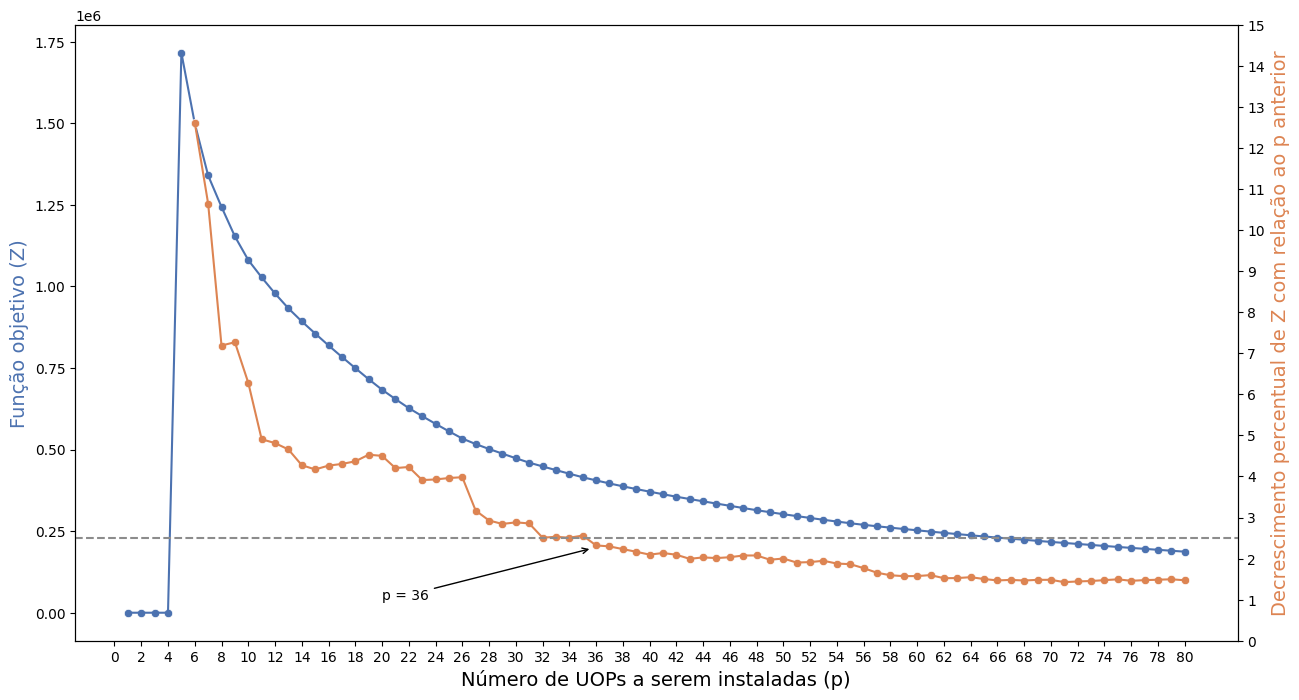

In [19]:
plot_fo(df_results_q0, "p")

In [20]:
# Verifica a distribuição das UOPs por solução factível:

df_uops_by_sols = get_uops_by_sol(df_feasibles)
df_uops_by_sols.head()

,p,q,name
0,5,0,CAPITAO LEONIDAS MARQUES 01
1,5,0,CURITIBA 04
2,5,0,IMBITUVA 01
3,5,0,LONDRINA 03
4,5,0,MARINGA 01


In [21]:
df_uops_by_sols.shape

(104083, 3)

In [22]:
# Filtra só o range desejado:

p = 36
range_p = [p for p in range(p, 50+1)]
print(range_p)
print(len(range_p))
df_uops_by_sols_range = df_uops_by_sols[df_uops_by_sols['p'].isin(range_p)].copy()
df_uops_by_sols_range.head()

[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
15


,p,q,name
15388,36,0,APUCARANA 01
15389,36,0,ARAPONGAS 03
15390,36,0,UOP06-DEL01-PR
15391,36,0,CAMPINA GRANDE DO SUL 03
15392,36,0,CAMPINA GRANDE DO SUL 06


In [23]:
df_uops_all_range_q0 = agg_and_merge_uops(df_uops_base, df_uops_by_sols_range, len(range_p), q=0)

In [24]:
df_uops_all_range_q0.head()

,name,municipality,is_uop,n_accidents,microregion,mesoregion,immediate_region,mun_name_orig,n,pct_solutions,UOP,Município,Atual,Soluções
0,CASCAVEL 04,CASCAVEL,False,442.0000,CASCAVEL,OESTE PARANAENSE,CASCAVEL,Cascavel,15.0000,100.0000,CASCAVEL 04,Cascavel,Não,15 (100%)
1,CURITIBA 03,CURITIBA,False,2035.0000,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,Curitiba,15.0000,100.0000,CURITIBA 03,Curitiba,Não,15 (100%)
2,UOP06-DEL01-PR,BALSA NOVA,True,189.0000,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,Balsa Nova,15.0000,100.0000,UOP06-DEL01-PR,Balsa Nova,Sim,15 (100%)
3,UOP01-DEL02-PR,PATO BRANCO,True,221.0000,PATO BRANCO,SUDOESTE PARANAENSE,PATO BRANCO,Pato Branco,15.0000,100.0000,UOP01-DEL02-PR,Pato Branco,Sim,15 (100%)
4,CAMPINA GRANDE DO SUL 03,CAMPINA GRANDE DO SUL,False,403.0000,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,Campina Grande do Sul,15.0000,100.0000,CAMPINA GRANDE DO SUL 03,Campina Grande do Sul,Não,15 (100%)


In [25]:
df_uops_all_range_q0.shape

(419, 14)

In [26]:
# Quadrantes não usados
df_0 = df_uops_all_range_q0[df_uops_all_range_q0['pct_solutions'] == 0].copy()
df_0.shape

(361, 14)

In [27]:
df_0[df_0['is_uop'] == True].shape

(26, 14)

In [28]:
df_0[df_0['is_uop'] == False].shape

(335, 14)

In [29]:
df_choosen = df_uops_all_range_q0[(df_uops_all_range_q0['pct_solutions'] > 0)]
df_choosen.shape

(58, 14)

In [30]:
df_choosen_100 = df_choosen[df_choosen['pct_solutions'] == 100].copy()

In [31]:
df_choosen_100_current = df_choosen_100[df_choosen_100['is_uop'] == True].copy()
df_choosen_100_current.shape

(4, 14)

In [32]:
df_choosen_100_current = df_choosen_100_current.sort_values(by=['Município', 'UOP']).reset_index(drop=True)
df_choosen_100_current[''] = df_choosen_100_current.index+1
print(df_choosen_100_current[['', 'UOP', 'Município']].to_latex(index=False, multirow=True))

\begin{tabular}{rll}
\toprule
  &            UOP &   Município \\
\midrule
1 & UOP06-DEL01-PR &  Balsa Nova \\
2 & UOP05-DEL01-PR &   Paranaguá \\
3 & UOP02-DEL09-PR &   Paranavaí \\
4 & UOP01-DEL02-PR & Pato Branco \\
\bottomrule
\end{tabular}



/var/folders/j1/pt3jwk353xqck3ls5h5twtn80000gn/T/ipykernel_43319/1496208111.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_choosen_100_current[['', 'UOP', 'Município']].to_latex(index=False, multirow=True))


In [33]:
df_choosen_100_candidate = df_choosen_100[df_choosen_100['is_uop'] == False].copy()
df_choosen_100_candidate.shape

(25, 14)

In [34]:
df_choosen_100_candidate = df_choosen_100_candidate.sort_values(by=['Município', 'UOP']).reset_index(drop=True)
df_choosen_100_candidate[''] = df_choosen_100_candidate.index+1
print(df_choosen_100_candidate[['', 'UOP', 'Município']].to_latex(index=False, multirow=True))

\begin{tabular}{rll}
\toprule
   &                          UOP &                 Município \\
\midrule
 1 &                 APUCARANA 01 &                 Apucarana \\
 2 &                 ARAPONGAS 03 &                 Arapongas \\
 3 &     CAMPINA GRANDE DO SUL 03 &     Campina Grande do Sul \\
 4 &     CAMPINA GRANDE DO SUL 06 &     Campina Grande do Sul \\
 5 &               CAMPO LARGO 04 &               Campo Largo \\
 6 &  CAPITAO LEONIDAS MARQUES 01 &  Capitão Leônidas Marques \\
 7 &                  CASCAVEL 04 &                  Cascavel \\
 8 &         CORNELIO PROCOPIO 02 &         Cornélio Procópio \\
 9 &                  CURITIBA 01 &                  Curitiba \\
10 &                  CURITIBA 03 &                  Curitiba \\
11 &                  CURITIBA 06 &                  Curitiba \\
12 &             FOZ DO IGUACU 04 &             Foz do Iguaçu \\
13 &                    IBAITI 01 &                    Ibaiti \\
14 &                     IRATI 02 &                

/var/folders/j1/pt3jwk353xqck3ls5h5twtn80000gn/T/ipykernel_43319/18753206.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_choosen_100_candidate[['', 'UOP', 'Município']].to_latex(index=False, multirow=True))


In [35]:
# concatena as duas tabelas:

df_concat = pd.concat([df_choosen_100_current, df_choosen_100_candidate], ignore_index=True)
df_concat[''] = df_concat.index+1
print(df_concat[['', 'UOP', 'Atual', 'Município']].to_latex(index=False, multirow=True))

\begin{tabular}{rlll}
\toprule
   &                          UOP & Atual &                 Município \\
\midrule
 1 &               UOP06-DEL01-PR &   Sim &                Balsa Nova \\
 2 &               UOP05-DEL01-PR &   Sim &                 Paranaguá \\
 3 &               UOP02-DEL09-PR &   Sim &                 Paranavaí \\
 4 &               UOP01-DEL02-PR &   Sim &               Pato Branco \\
 5 &                 APUCARANA 01 &   Não &                 Apucarana \\
 6 &                 ARAPONGAS 03 &   Não &                 Arapongas \\
 7 &     CAMPINA GRANDE DO SUL 03 &   Não &     Campina Grande do Sul \\
 8 &     CAMPINA GRANDE DO SUL 06 &   Não &     Campina Grande do Sul \\
 9 &               CAMPO LARGO 04 &   Não &               Campo Largo \\
10 &  CAPITAO LEONIDAS MARQUES 01 &   Não &  Capitão Leônidas Marques \\
11 &                  CASCAVEL 04 &   Não &                  Cascavel \\
12 &         CORNELIO PROCOPIO 02 &   Não &         Cornélio Procópio \\
13 &       

/var/folders/j1/pt3jwk353xqck3ls5h5twtn80000gn/T/ipykernel_43319/3937394119.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_concat[['', 'UOP', 'Atual', 'Município']].to_latex(index=False, multirow=True))


In [36]:
df_choosen_lt100 = df_choosen[df_choosen['pct_solutions'] < 100].copy()
df_choosen_lt100.shape

(29, 14)

In [37]:
df_choosen_lt100 = df_choosen_lt100.sort_values(by=['Atual', 'pct_solutions', 'Município', 'UOP'], ascending=[False, False, True, True]).reset_index(drop=True)
df_choosen_lt100[''] = df_choosen_lt100.index+1
print(df_choosen_lt100[['', 'UOP', 'Atual', 'Município', 'Soluções']].to_latex(index=False, multirow=True))

\begin{tabular}{rllll}
\toprule
   &                        UOP & Atual &               Município & Soluções \\
\midrule
 1 &             UOP04-DEL01-PR &   Sim &               Guaratuba & 12 (80\%) \\
 2 &             UOP02-DEL06-PR &   Sim & Marechal Cândido Rondon &  8 (53\%) \\
 3 &             UOP01-DEL04-PR &   Sim &                Cascavel &  2 (13\%) \\
 4 &             MANDIRITUBA 02 &   Não &             Mandirituba & 14 (93\%) \\
 5 &            CAMPO MOURAO 02 &   Não &            Campo Mourão & 13 (87\%) \\
 6 &                 UBIRATA 04 &   Não &                 Ubiratã & 13 (87\%) \\
 7 &              GUARAPUAVA 03 &   Não &              Guarapuava & 12 (80\%) \\
 8 &           PRUDENTOPOLIS 02 &   Não &           Prudentópolis & 12 (80\%) \\
 9 &                MORRETES 02 &   Não &                Morretes & 11 (73\%) \\
10 &                MARIALVA 01 &   Não &                Marialva & 10 (67\%) \\
11 &              GUARANIACU 01 &   Não &              Guaraniaçu &  

/var/folders/j1/pt3jwk353xqck3ls5h5twtn80000gn/T/ipykernel_43319/2961092546.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_choosen_lt100[['', 'UOP', 'Atual', 'Município', 'Soluções']].to_latex(index=False, multirow=True))


In [38]:
# Considerando a solução p = 36 e q = 0...

df_plot = df_uops_by_sols_range[(df_uops_by_sols_range['p'].isin(range_p)) & (df_uops_by_sols_range['q'] == 0)].copy()
df_plot = df_plot[df_plot['name'].isin(df_choosen_lt100['name'])].copy()
df_plot.head()


,p,q,name
15394,36,0,CANTAGALO 01
15401,36,0,FAROL 02
15403,36,0,GUARANIACU 01
15404,36,0,GUARAPUAVA 08
15405,36,0,UOP04-DEL01-PR


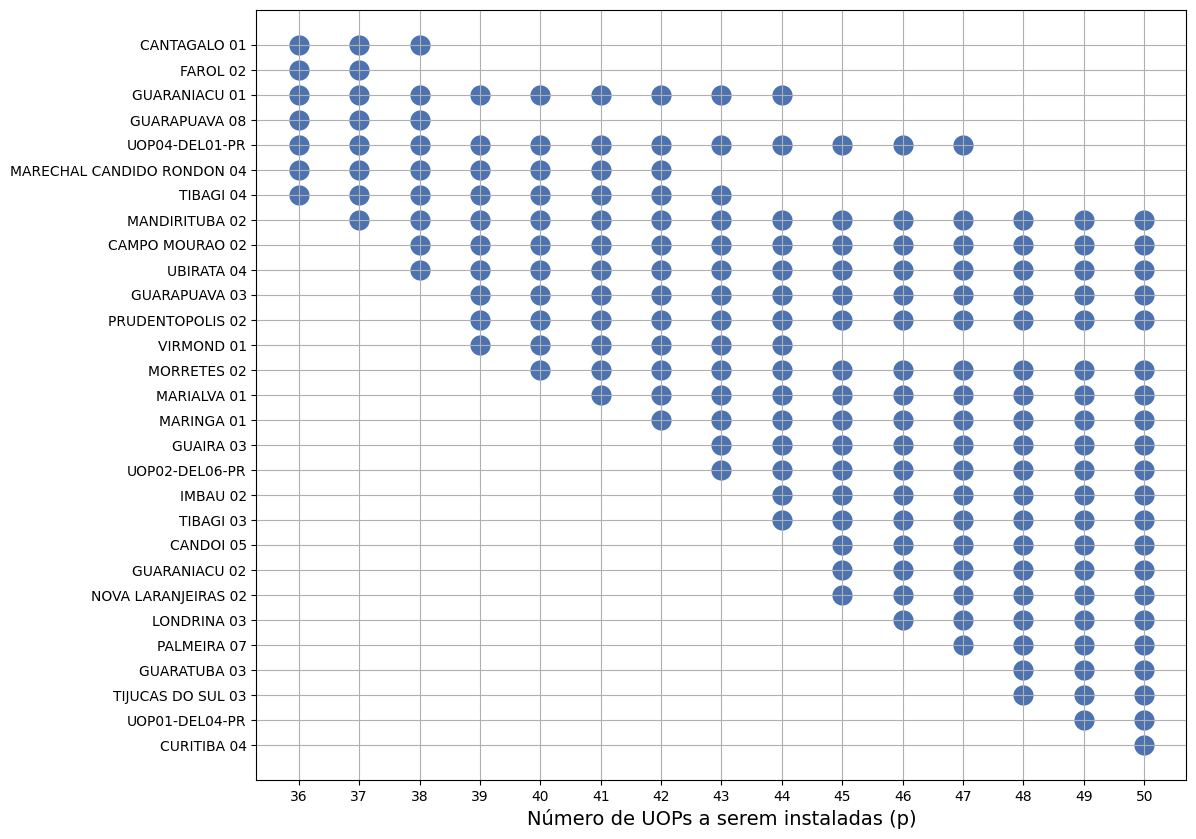

In [39]:
plot_uops_by_sol(df_plot, range_p, grid=True, figsize=(12,10), size=250)

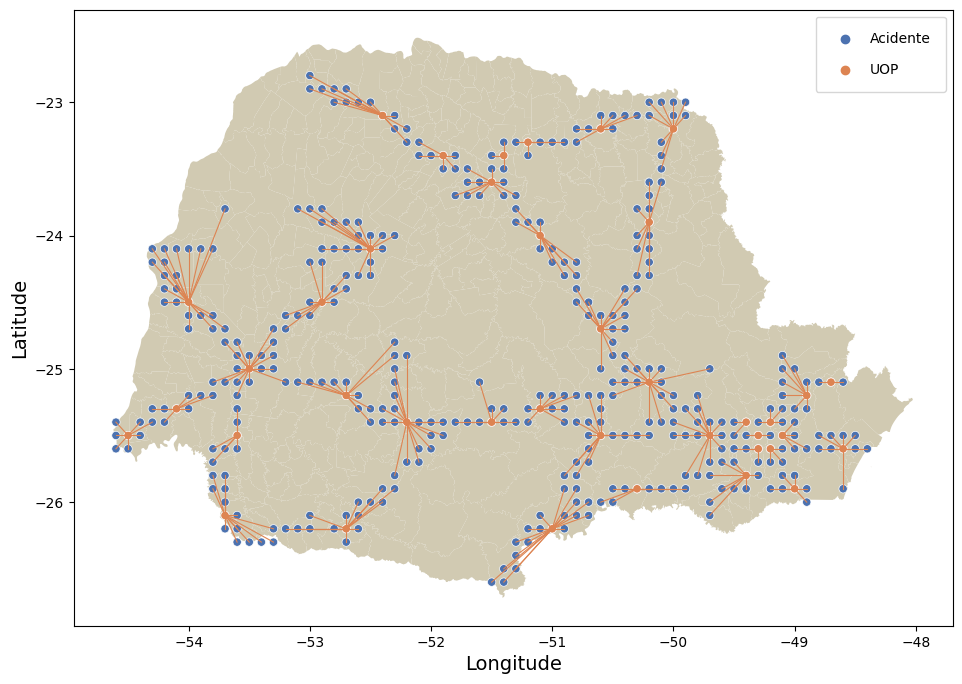

In [40]:
plot_solutions_map(q=0, p=39)

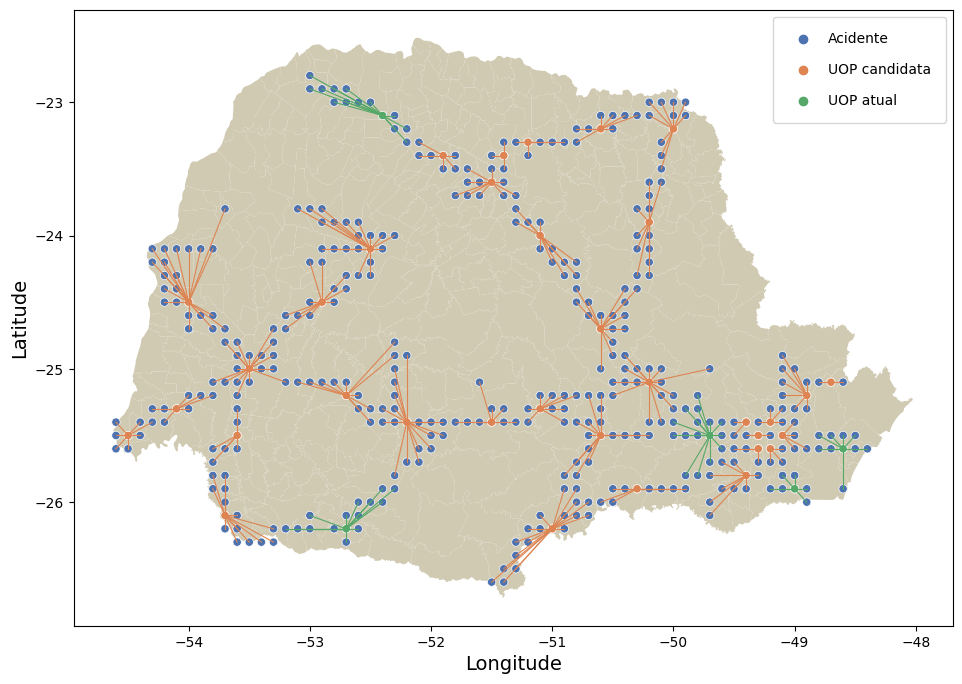

In [41]:
plot_solutions_map2(q=0, p=39)

In [42]:
def get_df_list_of_uops_to_latex(q, p, df_uops_base):
    df_sol = get_solution_details(q=q, p=p)
    uops = df_sol['median_name'].unique()

    df_uops = df_uops_base[df_uops_base['name'].isin(uops)].sort_values(by=['is_uop', 'name'], ascending=[False, True]).reset_index(drop=True)
    df_uops[''] = df_uops.index+1
    df_uops['Atual'] = np.where(df_uops['is_uop'] == True, 'Sim', 'Não')

    return df_uops

In [43]:
df_uops_p39_q0 = get_df_list_of_uops_to_latex(q=0, p=39, df_uops_base=df_uops_base)
print(df_uops_p39_q0[['', 'name', 'Atual', 'mun_name_orig']].to_latex(index=False, multirow=True))

\begin{tabular}{rlll}
\toprule
   &                         name & Atual &             mun\_name\_orig \\
\midrule
 1 &               UOP01-DEL02-PR &   Sim &               Pato Branco \\
 2 &               UOP02-DEL09-PR &   Sim &                 Paranavaí \\
 3 &               UOP04-DEL01-PR &   Sim &                 Guaratuba \\
 4 &               UOP05-DEL01-PR &   Sim &                 Paranaguá \\
 5 &               UOP06-DEL01-PR &   Sim &                Balsa Nova \\
 6 &                 APUCARANA 01 &   Não &                 Apucarana \\
 7 &                 ARAPONGAS 03 &   Não &                 Arapongas \\
 8 &     CAMPINA GRANDE DO SUL 03 &   Não &     Campina Grande do Sul \\
 9 &     CAMPINA GRANDE DO SUL 06 &   Não &     Campina Grande do Sul \\
10 &               CAMPO LARGO 04 &   Não &               Campo Largo \\
11 &              CAMPO MOURAO 02 &   Não &              Campo Mourão \\
12 &  CAPITAO LEONIDAS MARQUES 01 &   Não &  Capitão Leônidas Marques \\
13 &     

/var/folders/j1/pt3jwk353xqck3ls5h5twtn80000gn/T/ipykernel_43319/3644011508.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_uops_p39_q0[['', 'name', 'Atual', 'mun_name_orig']].to_latex(index=False, multirow=True))


## Expansão da rede

In [44]:
# Expansão de 42 para 43 medianas

uop_alocada = "UOP02-DEL06-PR"
uop_proposta = "MARECHAL CANDIDO RONDON 04"
q = 0
p = 43
df_sol = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-10-09 18:56:43.531 | INFO     | __main__:get_realoc_solution:201 - FO inicial: 348355.5429196706
2023-10-09 18:56:43.532 | INFO     | __main__:get_realoc_solution:202 - FO final: 350120.5369462591
2023-10-09 18:56:43.532 | INFO     | __main__:get_realoc_solution:203 - Variação da FO: 1764.9940265885089 | 0.51%
2023-10-09 18:56:43.533 | INFO     | __main__:get_realoc_solution:204 - Distância entre UOP02-DEL06-PR e MARECHAL CANDIDO RONDON 04: 11.12km


In [45]:
# Expansão de 43 para 44 medianas

uop_alocada = "TIBAGI 03"
uop_proposta = "TIBAGI 04"
q = 0
p = 44
df_sol = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-10-09 18:56:44.801 | INFO     | __main__:get_realoc_solution:201 - FO inicial: 341285.76515210804
2023-10-09 18:56:44.802 | INFO     | __main__:get_realoc_solution:202 - FO final: 344470.9774284822
2023-10-09 18:56:44.802 | INFO     | __main__:get_realoc_solution:203 - Variação da FO: 3185.2122763741645 | 0.93%
2023-10-09 18:56:44.803 | INFO     | __main__:get_realoc_solution:204 - Distância entre TIBAGI 03 e TIBAGI 04: 15.02km


In [46]:
# Expansão de 44 para 45 medianas

uop_alocada = "GUARANIACU 02"
uop_proposta = "GUARANIACU 01"
q = 0
p = 45
df_sol = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-10-09 18:56:45.275 | INFO     | __main__:get_realoc_solution:201 - FO inicial: 334419.24090716755
2023-10-09 18:56:45.275 | INFO     | __main__:get_realoc_solution:202 - FO final: 338179.7335842815
2023-10-09 18:56:45.276 | INFO     | __main__:get_realoc_solution:203 - Variação da FO: 3760.4926771139726 | 1.12%
2023-10-09 18:56:45.276 | INFO     | __main__:get_realoc_solution:204 - Distância entre GUARANIACU 02 e GUARANIACU 01: 23.0km


In [47]:
# Expansão de 44 para 45 medianas

uop_alocada = "CANDOI 05"
uop_proposta = "VIRMOND 01"
q = 0
p = 45
df_sol = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-10-09 18:56:45.622 | INFO     | __main__:get_realoc_solution:201 - FO inicial: 334419.24090716755
2023-10-09 18:56:45.623 | INFO     | __main__:get_realoc_solution:202 - FO final: 336733.0120455742
2023-10-09 18:56:45.623 | INFO     | __main__:get_realoc_solution:203 - Variação da FO: 2313.7711384066497 | 0.69%
2023-10-09 18:56:45.623 | INFO     | __main__:get_realoc_solution:204 - Distância entre CANDOI 05 e VIRMOND 01: 22.95km


In [48]:
# Expansão de 47 para 48 medianas

uop_alocada = "GUARATUBA 03"
uop_proposta = "UOP04-DEL01-PR"
q = 0
p = 48
df_sol = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-10-09 18:56:46.714 | INFO     | __main__:get_realoc_solution:201 - FO inicial: 314159.98963128845
2023-10-09 18:56:46.720 | INFO     | __main__:get_realoc_solution:202 - FO final: 315113.2269278284
2023-10-09 18:56:46.726 | INFO     | __main__:get_realoc_solution:203 - Variação da FO: 953.2372965399409 | 0.3%
2023-10-09 18:56:46.729 | INFO     | __main__:get_realoc_solution:204 - Distância entre GUARATUBA 03 e UOP04-DEL01-PR: 10.0km


In [49]:
def get_uops_by_sols(df_uops_by_sols, q, p, pmax):
    df_out = df_uops_by_sols[(df_uops_by_sols['q'] == q) & (df_uops_by_sols['p'] >= p) & (df_uops_by_sols['p'] <= pmax)].copy()
    df_out = df_out.sort_values(by=['p', 'name']).reset_index(drop=True)
    return df_out

def replace_uops(df, dict_replacements):
    for rep in dict_replacements:
        df['name'] = np.where(
            (df['p'] >= rep['sol']) & (df['name'] == rep['from']),
            rep['to'],
            df['name']
        )
    return df

def get_dict_uops(df):
    dict_uops = {}
    for p, data in df.groupby('p'):
        names = data['name'].to_list()
        if len(dict_uops) == 0:
            dict_uops[p] = {'names': names, 'names_to_add':[], 'names_to_del': []}
        else:
            last_p = max(dict_uops.keys())
            last_names = dict_uops[last_p]['names']
            names_to_add = [x for x in names if x not in last_names]
            names_to_del = [x for x in last_names if x not in names]
            dict_uops[p] = {'names': names, 'names_to_add': names_to_add, 'names_to_del': names_to_del}

    return dict_uops

def get_expansion_plan(dict_uops):
    sols = []
    names_to_add = []
    for key, value in dict_uops.items():
        if key > 39:
            sols.append(key)
            names_to_add.append(value['names_to_add'][0])

    df_adds = pd.DataFrame({'sol': sols, 'name': names_to_add})
    return df_adds

In [50]:
df = get_uops_by_sols(df_uops_by_sols, q=0, p=39, pmax=50)

replacements = [{'sol': 43, 'from': 'UOP02-DEL06-PR', 'to': 'MARECHAL CANDIDO RONDON 04'},
                {'sol': 44, 'from': 'TIBAGI 03', 'to': 'TIBAGI 04'},
                {'sol': 45, 'from': 'GUARANIACU 02', 'to': 'GUARANIACU 01'},
                {'sol': 45, 'from': 'CANDOI 05', 'to': 'VIRMOND 01'},
                {'sol': 48, 'from': 'GUARATUBA 03', 'to': 'UOP04-DEL01-PR'}]

df = replace_uops(df, replacements)
dict_uops = get_dict_uops(df)
df_adds = get_expansion_plan(dict_uops)
df_adds = df_adds.merge(df_uops_base[['name', 'is_uop', 'mun_name_orig']], how='left', on='name')
df_adds['Atual'] = np.where(df_adds['is_uop'] == True, 'Sim', 'Não')
print(df_adds[['sol', 'name', 'Atual', 'mun_name_orig']].to_latex(index=False, multirow=True))


\begin{tabular}{rlll}
\toprule
 sol &                name & Atual &    mun\_name\_orig \\
\midrule
  40 &         MORRETES 02 &   Não &         Morretes \\
  41 &         MARIALVA 01 &   Não &         Marialva \\
  42 &          MARINGA 01 &   Não &          Maringá \\
  43 &           GUAIRA 03 &   Não &           Guaíra \\
  44 &            IMBAU 02 &   Não &            Imbaú \\
  45 & NOVA LARANJEIRAS 02 &   Não & Nova Laranjeiras \\
  46 &         LONDRINA 03 &   Não &         Londrina \\
  47 &         PALMEIRA 07 &   Não &         Palmeira \\
  48 &   TIJUCAS DO SUL 03 &   Não &   Tijucas do Sul \\
  49 &      UOP01-DEL04-PR &   Sim &         Cascavel \\
  50 &         CURITIBA 04 &   Não &         Curitiba \\
\bottomrule
\end{tabular}



/var/folders/j1/pt3jwk353xqck3ls5h5twtn80000gn/T/ipykernel_43319/599365471.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_adds[['sol', 'name', 'Atual', 'mun_name_orig']].to_latex(index=False, multirow=True))


# Soluções restritas (SR15)

In [51]:
# Carrega os resultados:
df_all_results = get_all_results()

# Soluções livres
df_results_p = get_df_results(df_all_results, p=39)
df_results_p['obj_function_abs_pct_change'] = df_results_p['obj_function_abs_pct_change'].fillna(0)
df_results_p

,name,p,q,solver,is_feasible,is_optimal,obj_function,obj_function_abs_diff,obj_function_abs_pct_change
764,model_p39_q0_results,39,0,gurobi,True,True,378908.1202,0.0000,0.0000
765,model_p39_q1_results,39,1,gurobi,True,True,378908.1202,0.0000,0.0000
766,model_p39_q2_results,39,2,gurobi,True,True,378908.1202,0.0000,0.0000
767,model_p39_q3_results,39,3,gurobi,True,True,378908.1202,0.0000,0.0000
768,model_p39_q4_results,39,4,gurobi,True,True,378908.1202,0.0000,0.0000
769,model_p39_q5_results,39,5,gurobi,True,True,378908.1202,0.0000,0.0000
770,model_p39_q6_results,39,6,gurobi,True,True,378996.9816,88.8614,0.0235
771,model_p39_q7_results,39,7,gurobi,True,True,379130.3858,133.4043,0.0352
772,model_p39_q8_results,39,8,gurobi,True,True,379324.7975,194.4117,0.0513
773,model_p39_q9_results,39,9,gurobi,True,True,379677.8692,353.0717,0.0931


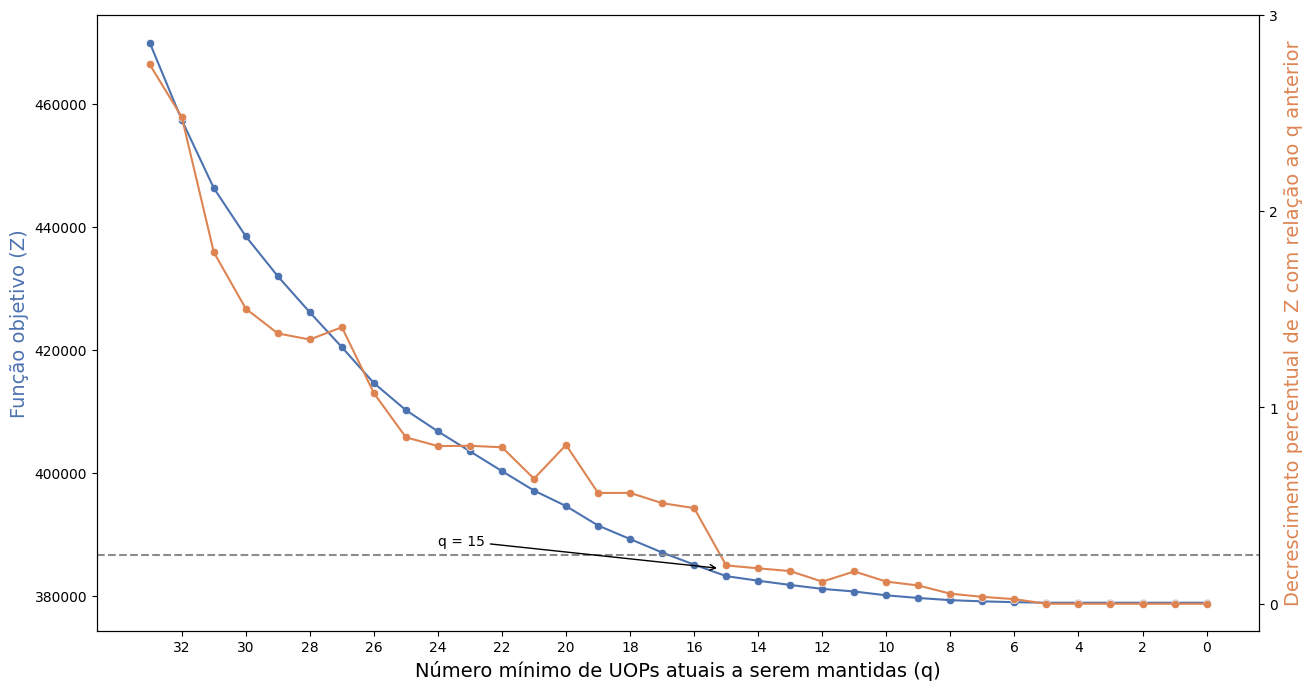

In [52]:
plot_fo(
    df_results_p, 
    x_param="q", 
    xtick_min=0, 
    xtick_max=33, 
    invert_x=True, 
    pct_cutover=0.25, 
    p2_ytick_max=3, 
    xlabel="Número mínimo de UOPs atuais a serem mantidas (q)",
    p2_ylabel = "Decrescimento percentual de Z com relação ao q anterior",
    arrow_txt="q = 15",
    arrow_xy=(15.2, 0.18),
    arrow_txt_xy=(24, 0.3),)

In [53]:
df_sol_p39_q15 = get_solution_details(p=39, q=15)
df_sol_p39_q0 = get_solution_details(p=39, q=0)

def calculate_dif_fo(df_irrestrita, df_restrita):
    fo_irrestrita = df_irrestrita['obj_function'].sum()
    fo_restrita = df_restrita['obj_function'].sum()
    pct_dif = (fo_restrita - fo_irrestrita)/fo_irrestrita*100

    logger.info(f"FO irrestrita: {fo_irrestrita}")
    logger.info(f"FO restrita: {fo_restrita}")
    logger.info(f"Variação: {round(pct_dif,2)}%")

In [54]:
calculate_dif_fo(df_irrestrita=df_sol_p39_q0, df_restrita=df_sol_p39_q15)

2023-10-09 18:56:51.053 | INFO     | __main__:calculate_dif_fo:9 - FO irrestrita: 378908.1201697493
2023-10-09 18:56:51.055 | INFO     | __main__:calculate_dif_fo:10 - FO restrita: 383230.178389068
2023-10-09 18:56:51.056 | INFO     | __main__:calculate_dif_fo:11 - Variação: 1.14%


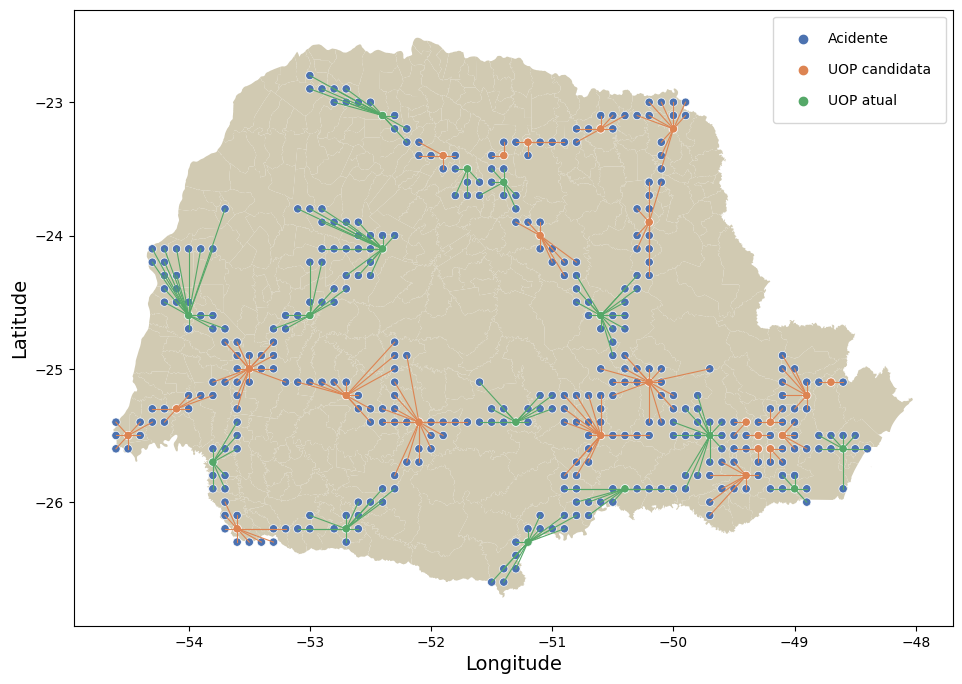

In [55]:
plot_solutions_map2(p=39, q=15)

In [56]:
df_uops_p39_q15 = get_df_list_of_uops_to_latex(q=15, p=39, df_uops_base=df_uops_base)
df_uops_p39_q15.head()

,name,municipality,is_uop,n_accidents,microregion,mesoregion,immediate_region,mun_name_orig,,Atual
0,UOP01-DEL02-PR,PATO BRANCO,True,221.0000,PATO BRANCO,SUDOESTE PARANAENSE,PATO BRANCO,Pato Branco,1,Sim
1,UOP01-DEL08-PR,GUARAPUAVA,True,75.0000,GUARAPUAVA,CENTRO-SUL PARANAENSE,GUARAPUAVA,Guarapuava,2,Sim
2,UOP01-DEL09-PR,MANDAGUARI,True,229.0000,MARINGA,NORTE CENTRAL PARANAENSE,MARINGA,Mandaguari,3,Sim
3,UOP02-DEL02-PR,PLANALTO,True,73.0000,CAPANEMA,SUDOESTE PARANAENSE,FRANCISCO BELTRAO,Planalto,4,Sim
4,UOP02-DEL03-PR,TIBAGI,True,31.0000,TELEMACO BORBA,CENTRO ORIENTAL PARANAENSE,TELEMACO BORBA,Tibagi,5,Sim


In [57]:
uops_to_delete = [uop for uop in list(df_uops_p39_q0['name']) if uop not in list(df_uops_p39_q15['name'])]
uops_to_add = [uop for uop in list(df_uops_p39_q15['name']) if uop not in list(df_uops_p39_q0['name'])]

In [58]:
df_to_delete = df_quadrants[df_quadrants['name'].isin(uops_to_delete)].sort_values(by=['is_uop', 'name'], ascending=[False,True]).reset_index(drop=True)
df_to_add = df_quadrants[df_quadrants['name'].isin(uops_to_add)].sort_values(by=['is_uop', 'name'], ascending=[False,True]).reset_index(drop=True)

In [59]:
df_to_delete.head()

,latitude,longitude,municipality,name,n_accidents,n_acc_holiday,n_acc_weekend,n_injuried,n_dead,cluster,dist_max,is_uop,is_only_uop
0,-23.6000,-51.5000,APUCARANA,APUCARANA 01,254.0000,7.0000,66.0000,68.0000,15.0000,4,120.0000,False,False
1,-24.1000,-52.5000,CAMPO MOURAO,CAMPO MOURAO 02,28.0000,1.0000,9.0000,22.0000,3.0000,1,180.0000,False,False
2,-25.5000,-53.6000,CAPITAO LEONIDAS MARQUES,CAPITAO LEONIDAS MARQUES 01,53.0000,8.0000,20.0000,24.0000,4.0000,1,180.0000,False,False
3,-25.4000,-51.5000,GUARAPUAVA,GUARAPUAVA 03,164.0000,8.0000,53.0000,62.0000,17.0000,3,120.0000,False,False
4,-24.5000,-54.0000,MARECHAL CANDIDO RONDON,MARECHAL CANDIDO RONDON 04,22.0000,0.0000,8.0000,10.0000,1.0000,1,180.0000,False,False


In [60]:
# df_to_delete.head()

# df_a = pd.DataFrame({'name': ['UOP01-DEL08-PR', 'UOP01-DEL09-PR', 'UOP02-DEL02-PR'], 'latitude': [-25.4000, -23.5000, -25.7000], 'longitude': [-51.3000, -51.7000, -53.8000]})
# df_b = pd.DataFrame({'name': ['APUCARANA 01', 'CAMPO MOURAO 02', 'CAPITAO LEONIDAS MARQUES 01'], 'latitude': [-23.6000, -24.1000, -25.5000], 'longitude': [-51.500, -52.5000, -53.6000]})

In [61]:
from scipy.optimize import linear_sum_assignment

df_a = df_to_delete.copy()
df_b = df_to_add.copy()

distances = get_distance_matrix(
    lat_rows=df_a['latitude'],
    lon_rows=df_a['longitude'],
    lat_cols=df_b['latitude'],
    lon_cols=df_b['longitude'],)

# Resolve o Problema do Atribuição Linear (Emparelhamento Mínimo)
row_indices, col_indices = linear_sum_assignment(distances)

# Cria um novo DataFrame com as informações dos postos mais próximos e as distâncias
df_result = pd.DataFrame({
    'uop_a': df_a['name'].iloc[row_indices],
    'uop_b': df_b['name'].iloc[col_indices],
    'dist': distances[row_indices, col_indices]
})

df_dists = df_result.sort_values(by='dist').reset_index(drop=True)

In [62]:
df_dists

,uop_a,uop_b,dist
0,SAO MATEUS DO SUL 05,UOP03-DEL07-PR,10.0026
1,VIRMOND 01,CANTAGALO 01,10.0446
2,CAMPO MOURAO 02,UOP01-DEL09-PR,10.1503
3,TIBAGI 04,UOP03-DEL09-PR,11.1195
4,MARECHAL CANDIDO RONDON 04,UOP02-DEL06-PR,11.1195
5,SANTO ANTONIO DO SUDOESTE 02,UOP03-DEL04-PR,14.9422
6,UBIRATA 04,UOP04-DEL02-PR,15.0314
7,GUARAPUAVA 03,UOP02-DEL03-PR,20.0893
8,UNIAO DA VITORIA 02,BARRACAO 04,22.8357
9,APUCARANA 01,UOP01-DEL08-PR,23.2220


In [63]:
len(df_dists['uop_a'].unique())

12

In [64]:
len(df_dists['uop_b'].unique())

12

In [65]:
df_dists[''] = df_dists.index + 1
print(df_dists[['', 'uop_a', 'uop_b', 'dist']].to_latex(index=False, multirow=True))

\begin{tabular}{rllr}
\toprule
   &                        uop\_a &          uop\_b &     dist \\
\midrule
 1 &         SAO MATEUS DO SUL 05 & UOP03-DEL07-PR &  10.0026 \\
 2 &                   VIRMOND 01 &   CANTAGALO 01 &  10.0446 \\
 3 &              CAMPO MOURAO 02 & UOP01-DEL09-PR &  10.1503 \\
 4 &                    TIBAGI 04 & UOP03-DEL09-PR &  11.1195 \\
 5 &   MARECHAL CANDIDO RONDON 04 & UOP02-DEL06-PR &  11.1195 \\
 6 & SANTO ANTONIO DO SUDOESTE 02 & UOP03-DEL04-PR &  14.9422 \\
 7 &                   UBIRATA 04 & UOP04-DEL02-PR &  15.0314 \\
 8 &                GUARAPUAVA 03 & UOP02-DEL03-PR &  20.0893 \\
 9 &          UNIAO DA VITORIA 02 &    BARRACAO 04 &  22.8357 \\
10 &                 APUCARANA 01 & UOP01-DEL08-PR &  23.2220 \\
11 &  CAPITAO LEONIDAS MARQUES 01 & UOP02-DEL02-PR &  29.9468 \\
12 &             PRUDENTOPOLIS 02 & UOP03-DEL02-PR & 191.4550 \\
\bottomrule
\end{tabular}



/var/folders/j1/pt3jwk353xqck3ls5h5twtn80000gn/T/ipykernel_43319/651063755.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_dists[['', 'uop_a', 'uop_b', 'dist']].to_latex(index=False, multirow=True))


## Expansão da rede

In [66]:
# Considerando a solução p = 39 e q = 15...
p = 39
q = 15

range_p_sr15 = [p for p in range(p, 50+1)]
df_plot = df_uops_by_sols[(df_uops_by_sols['p'].isin(range_p_sr15)) & (df_uops_by_sols_range['q'] == q)].copy()

In [67]:
50-p+1

12

In [68]:
uops_not_100 = df_plot.groupby('name').agg(n=('p', 'nunique')).reset_index().sort_values(by='n', ascending=False)
uops_not_100 = list(uops_not_100[uops_not_100['n'] < (50-p+1)]['name'])


df_plot = df_plot[df_plot['name'].isin(uops_not_100)].copy()
df_plot.head()

,p,q,name
19747,39,15,BARRACAO 04
19752,39,15,CANTAGALO 01
19759,39,15,GUARANIACU 01
19760,39,15,UOP01-DEL08-PR
19761,39,15,UOP04-DEL01-PR


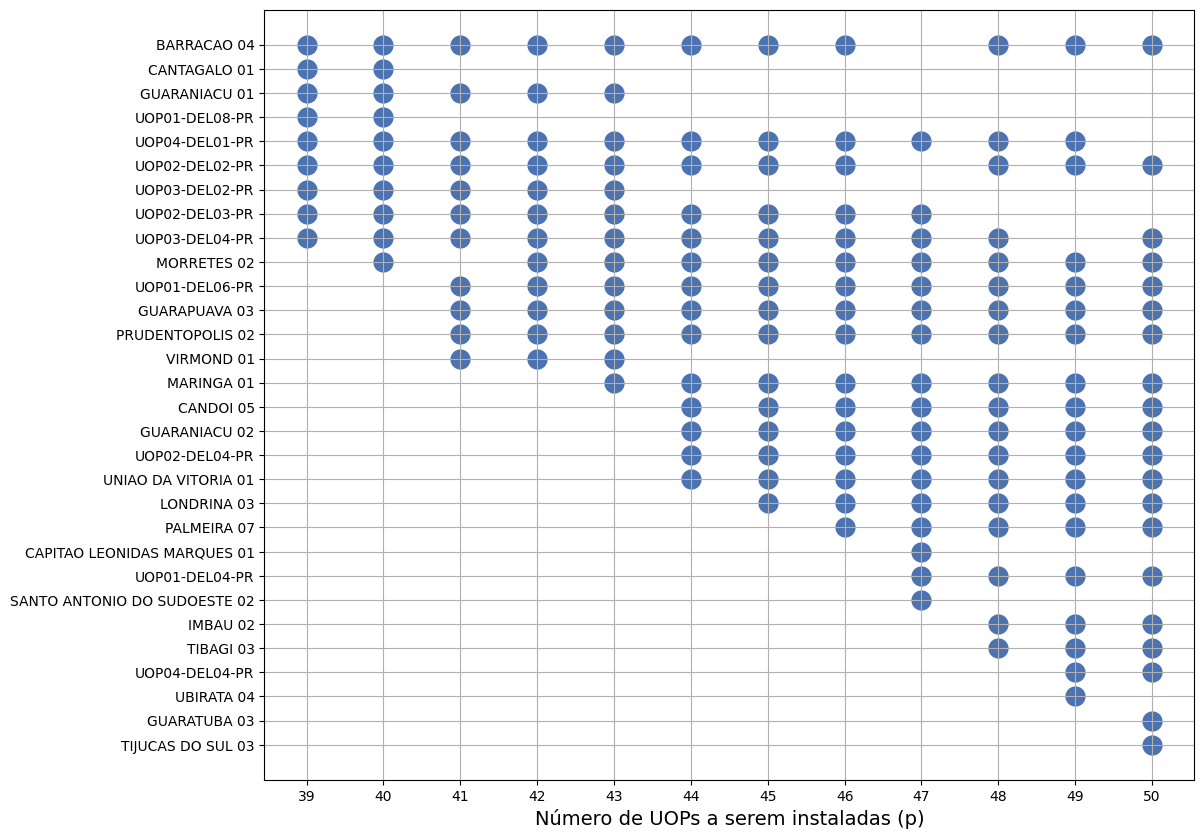

In [69]:
plot_uops_by_sol(df_plot, range_p_sr15, grid=True, figsize=(12,10), size=250)

In [70]:
# De 39 p/ 40:
#   Entra: MORRETES 03

# De 49 p/ 41:
#   Entra: PRUDENTOPOLIS 02 e UOP01-DEL06-PR
#   Sai: MORRETES 02

# De 41 p/ 42:
#   Entra: MORRETES 02

# De 42 p/ 43:
#   Entra: MARINGA 01

# De 43 p/ 44:
#   Entra: UOP02-DEL04-PR

# De 44 p/ 45:
#   Entra: LONDRINA 03

# De 45 p/ 46:
#   Entra: PALMEIRA 07

# De 46 p/ 47:
#   Entra: UOP01-DEL04-PR

# De 47 p/ 48:
#   Entra: TIBAGI 03

# De 48 p/ 49:
#   Entra: UOP04-DEL04-PR

# De 49 p/ 50:
#   Entra: TIJUCAS DO SUL 03

In [71]:
print(dict_uops[50]['names_to_add'])
print(dict_uops[50]['names_to_del'])

['CURITIBA 04']
[]


In [72]:
# Expansão de 40 para 41 medianas

uop_alocada = "PRUDENTOPOLIS 02"
uop_proposta = "MORRETES 02"
q = 15
p = 41
df_sol = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-10-09 18:57:01.750 | INFO     | __main__:get_realoc_solution:201 - FO inicial: 366963.7532290097
2023-10-09 18:57:01.751 | INFO     | __main__:get_realoc_solution:202 - FO final: 441805.40218083846
2023-10-09 18:57:01.751 | INFO     | __main__:get_realoc_solution:203 - Variação da FO: 74841.64895182877 | 20.39%
2023-10-09 18:57:01.752 | INFO     | __main__:get_realoc_solution:204 - Distância entre PRUDENTOPOLIS 02 e MORRETES 02: 233.32km


In [73]:
# Expansão de 40 para 41 medianas

uop_alocada = "VIRMOND 01"
uop_proposta = "CANTAGALO 01"
q = 15
p = 41
df_sol = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-10-09 18:57:02.311 | INFO     | __main__:get_realoc_solution:201 - FO inicial: 366963.7532290097
2023-10-09 18:57:02.311 | INFO     | __main__:get_realoc_solution:202 - FO final: 367000.67998366937
2023-10-09 18:57:02.312 | INFO     | __main__:get_realoc_solution:203 - Variação da FO: 36.92675465968205 | 0.01%
2023-10-09 18:57:02.312 | INFO     | __main__:get_realoc_solution:204 - Distância entre VIRMOND 01 e CANTAGALO 01: 10.04km


In [74]:
# Expansão de 40 para 41 medianas

uop_alocada = "GUARAPUAVA 03"
uop_proposta = "UOP01-DEL08-PR"
q = 15
p = 41
df_sol = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-10-09 18:57:02.757 | INFO     | __main__:get_realoc_solution:201 - FO inicial: 366963.7532290097
2023-10-09 18:57:02.758 | INFO     | __main__:get_realoc_solution:202 - FO final: 371738.6586178265
2023-10-09 18:57:02.759 | INFO     | __main__:get_realoc_solution:203 - Variação da FO: 4774.905388816842 | 1.3%
2023-10-09 18:57:02.759 | INFO     | __main__:get_realoc_solution:204 - Distância entre GUARAPUAVA 03 e UOP01-DEL08-PR: 20.09km


In [75]:
# Expansão de 43 para 44 medianas

uop_alocada = "GUARANIACU 02"
uop_proposta = "GUARANIACU 01"
q = 15
p = 44
df_sol = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-10-09 18:57:03.196 | INFO     | __main__:get_realoc_solution:201 - FO inicial: 344266.11065848754
2023-10-09 18:57:03.196 | INFO     | __main__:get_realoc_solution:202 - FO final: 347221.68775445106
2023-10-09 18:57:03.197 | INFO     | __main__:get_realoc_solution:203 - Variação da FO: 2955.5770959635265 | 0.86%
2023-10-09 18:57:03.197 | INFO     | __main__:get_realoc_solution:204 - Distância entre GUARANIACU 02 e GUARANIACU 01: 23.0km


In [76]:
# Expansão de 43 para 44 medianas

uop_alocada = "UNIAO DA VITORIA 01"
uop_proposta = "UOP03-DEL02-PR"
q = 15
p = 44
df_sol = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-10-09 18:57:03.597 | INFO     | __main__:get_realoc_solution:201 - FO inicial: 344266.11065848754
2023-10-09 18:57:03.598 | INFO     | __main__:get_realoc_solution:202 - FO final: 345316.43216998863
2023-10-09 18:57:03.598 | INFO     | __main__:get_realoc_solution:203 - Variação da FO: 1050.3215115010971 | 0.31%
2023-10-09 18:57:03.598 | INFO     | __main__:get_realoc_solution:204 - Distância entre UNIAO DA VITORIA 01 e UOP03-DEL02-PR: 14.94km


In [77]:
# Expansão de 43 para 44 medianas

uop_alocada = "CANDOI 05"
uop_proposta = "VIRMOND 01" # CANTAGALO 01
q = 15
p = 44
df_sol = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-10-09 18:57:04.024 | INFO     | __main__:get_realoc_solution:201 - FO inicial: 344266.11065848754
2023-10-09 18:57:04.025 | INFO     | __main__:get_realoc_solution:202 - FO final: 347819.4000186169
2023-10-09 18:57:04.025 | INFO     | __main__:get_realoc_solution:203 - Variação da FO: 3553.289360129391 | 1.03%
2023-10-09 18:57:04.026 | INFO     | __main__:get_realoc_solution:204 - Distância entre CANDOI 05 e VIRMOND 01: 22.95km


In [78]:
# Expansão de 46 para 47 medianas

uop_alocada = "CAPITAO LEONIDAS MARQUES 01"
uop_proposta = "UOP02-DEL02-PR"
q = 15
p = 47
df_sol = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-10-09 18:57:04.425 | INFO     | __main__:get_realoc_solution:201 - FO inicial: 323881.9898582203
2023-10-09 18:57:04.426 | INFO     | __main__:get_realoc_solution:202 - FO final: 326968.2362210457
2023-10-09 18:57:04.426 | INFO     | __main__:get_realoc_solution:203 - Variação da FO: 3086.246362825448 | 0.95%
2023-10-09 18:57:04.427 | INFO     | __main__:get_realoc_solution:204 - Distância entre CAPITAO LEONIDAS MARQUES 01 e UOP02-DEL02-PR: 29.95km


In [79]:
# Expansão de 46 para 47 medianas

uop_alocada = "SANTO ANTONIO DO SUDOESTE 02"
uop_proposta = "BARRACAO 04"
q = 15
p = 47
df_sol = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-10-09 18:57:05.526 | INFO     | __main__:get_realoc_solution:201 - FO inicial: 323881.9898582203
2023-10-09 18:57:05.527 | INFO     | __main__:get_realoc_solution:202 - FO final: 324814.5468397789
2023-10-09 18:57:05.527 | INFO     | __main__:get_realoc_solution:203 - Variação da FO: 932.5569815586205 | 0.29%
2023-10-09 18:57:05.528 | INFO     | __main__:get_realoc_solution:204 - Distância entre SANTO ANTONIO DO SUDOESTE 02 e BARRACAO 04: 14.94km


In [80]:
# Expansão de 47 para 48 medianas

uop_alocada = "IMBAU 02"
uop_proposta = "UOP02-DEL03-PR"
q = 15
p = 48
df_sol = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-10-09 18:57:05.844 | INFO     | __main__:get_realoc_solution:201 - FO inicial: 317093.01445737795
2023-10-09 18:57:05.845 | INFO     | __main__:get_realoc_solution:202 - FO final: 318968.6678435906
2023-10-09 18:57:05.845 | INFO     | __main__:get_realoc_solution:203 - Variação da FO: 1875.6533862126525 | 0.59%
2023-10-09 18:57:05.846 | INFO     | __main__:get_realoc_solution:204 - Distância entre IMBAU 02 e UOP02-DEL03-PR: 15.03km


In [81]:
# Expansão de 48 para 49 medianas

uop_alocada = "UBIRATA 04"
uop_proposta = "UOP03-DEL04-PR"
q = 15
p = 48
df_sol = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-10-09 18:57:06.347 | INFO     | __main__:get_realoc_solution:201 - FO inicial: 317093.01445737795
2023-10-09 18:57:06.348 | INFO     | __main__:get_realoc_solution:202 - FO final: 317093.01445737795
2023-10-09 18:57:06.348 | INFO     | __main__:get_realoc_solution:203 - Variação da FO: 0.0 | 0.0%
2023-10-09 18:57:06.349 | INFO     | __main__:get_realoc_solution:204 - Distância entre UBIRATA 04 e UOP03-DEL04-PR: 15.03km


In [82]:
# Expansão de 49 para 50 medianas

uop_alocada = "GUARATUBA 03"
uop_proposta = "UOP04-DEL01-PR"
q = 15
p = 50
df_sol = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-10-09 18:57:07.582 | INFO     | __main__:get_realoc_solution:201 - FO inicial: 304673.0754680093
2023-10-09 18:57:07.583 | INFO     | __main__:get_realoc_solution:202 - FO final: 305626.3127645492
2023-10-09 18:57:07.583 | INFO     | __main__:get_realoc_solution:203 - Variação da FO: 953.2372965399409 | 0.31%
2023-10-09 18:57:07.584 | INFO     | __main__:get_realoc_solution:204 - Distância entre GUARATUBA 03 e UOP04-DEL01-PR: 10.0km


In [83]:
# Expansão de 49 para 50 medianas

# Será ativar TIJUCAS DO SUL 03

In [84]:
df = get_uops_by_sols(df_uops_by_sols, q=15, p=39, pmax=50)

replacements = [{'sol': 41, 'from': 'VIRMOND 01', 'to': 'CANTAGALO 01'},
                {'sol': 41, 'from': 'GUARAPUAVA 03', 'to': 'UOP01-DEL08-PR'},
                {'sol': 41, 'from': 'VIRMOND 01', 'to': 'CANTAGALO 01'},
                {'sol': 41, 'from': 'PRUDENTOPOLIS 02', 'to': 'MORRETES 02'},
                {'sol': 42, 'from': 'MORRETES 02', 'to': 'PRUDENTOPOLIS 02'},
                {'sol': 44, 'from': 'GUARANIACU 02', 'to': 'GUARANIACU 01'},
                {'sol': 44, 'from': 'UNIAO DA VITORIA 01', 'to': 'UOP03-DEL02-PR'},
                {'sol': 44, 'from': 'CANDOI 05', 'to': 'CANTAGALO 01'},
                {'sol': 47, 'from': 'CAPITAO LEONIDAS MARQUES 01', 'to': 'UOP02-DEL02-PR'},
                {'sol': 47, 'from': 'SANTO ANTONIO DO SUDOESTE 02', 'to': 'BARRACAO 04'},
                {'sol': 48, 'from': 'IMBAU 02', 'to': 'UOP02-DEL03-PR'},
                {'sol': 49, 'from': 'UBIRATA 04', 'to': 'UOP03-DEL04-PR'},
                {'sol': 50, 'from': 'GUARATUBA 03', 'to': 'UOP04-DEL01-PR'}]

df = replace_uops(df, replacements)
dict_uops = get_dict_uops(df)
df_adds = get_expansion_plan(dict_uops)
df_adds = df_adds.merge(df_uops_base[['name', 'is_uop', 'mun_name_orig']], how='left', on='name')
df_adds['Atual'] = np.where(df_adds['is_uop'] == True, 'Sim', 'Não')
print(df_adds[['sol', 'name', 'Atual', 'mun_name_orig']].to_latex(index=False, multirow=True))

\begin{tabular}{rlll}
\toprule
 sol &              name & Atual &      mun\_name\_orig \\
\midrule
  40 &       MORRETES 02 &   Não &           Morretes \\
  41 &    UOP01-DEL06-PR &   Sim &             Guaíra \\
  42 &  PRUDENTOPOLIS 02 &   Não &      Prudentópolis \\
  43 &        MARINGA 01 &   Não &            Maringá \\
  44 &    UOP02-DEL04-PR &   Sim & Laranjeiras do Sul \\
  45 &       LONDRINA 03 &   Não &           Londrina \\
  46 &       PALMEIRA 07 &   Não &           Palmeira \\
  47 &    UOP01-DEL04-PR &   Sim &           Cascavel \\
  48 &         TIBAGI 03 &   Não &             Tibagi \\
  49 &    UOP04-DEL04-PR &   Sim &          Lindoeste \\
  50 & TIJUCAS DO SUL 03 &   Não &     Tijucas do Sul \\
\bottomrule
\end{tabular}



/var/folders/j1/pt3jwk353xqck3ls5h5twtn80000gn/T/ipykernel_43319/3068263630.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_adds[['sol', 'name', 'Atual', 'mun_name_orig']].to_latex(index=False, multirow=True))


# UOPs atuais

In [85]:
# Carrega os resultados:
df_all_results = get_all_results()
df_results_q33 = df_all_results[(df_all_results['p'] == df_all_results['q'])].copy()
df_results_q33 = calc_diff(df_results_q33)
df_results_q33


,name,p,q,solver,is_feasible,is_optimal,obj_function,obj_function_abs_diff,obj_function_abs_pct_change
1,model_p1_q1_results,1,1,gurobi,False,False,0.0000,0.0000,NaN
4,model_p2_q2_results,2,2,gurobi,False,False,0.0000,0.0000,NaN
8,model_p3_q3_results,3,3,gurobi,False,False,0.0000,0.0000,NaN
13,model_p4_q4_results,4,4,gurobi,False,False,0.0000,0.0000,NaN
19,model_p5_q5_results,5,5,gurobi,False,False,0.0000,0.0000,NaN
26,model_p6_q6_results,6,6,gurobi,True,True,1651759.0240,1651759.0240,inf
34,model_p7_q7_results,7,7,gurobi,True,True,1501872.1608,149886.8632,9.0744
43,model_p8_q8_results,8,8,gurobi,True,True,1356802.2865,145069.8743,9.6593
53,model_p9_q9_results,9,9,gurobi,True,True,1283919.5362,72882.7504,5.3717
64,model_p10_q10_results,10,10,gurobi,True,True,1219534.5873,64384.9489,5.0147


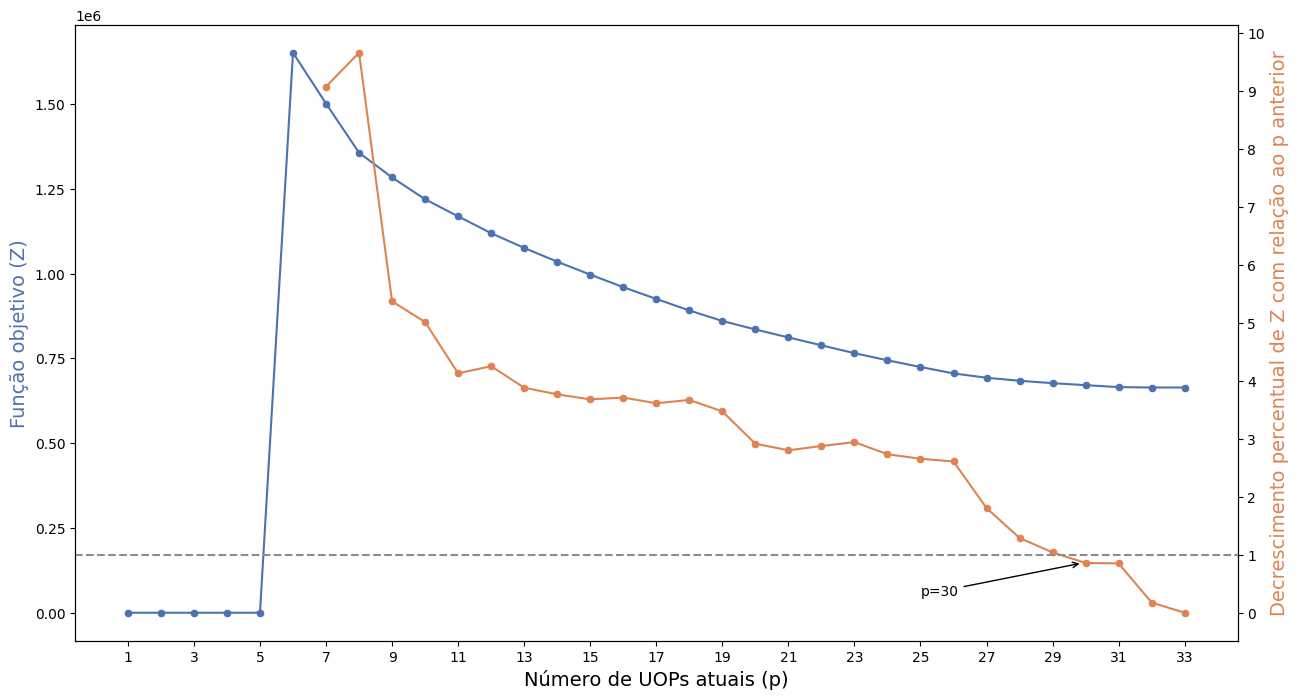

In [86]:
plot_fo(
    df_results_q33, 
    x_param="p", 
    xtick_min=1, 
    xtick_max=33, 
    invert_x=False, 
    pct_cutover=1, 
    p2_ytick_max=10, 
    xlabel="Número de UOPs atuais (p)",
    p2_ylabel = "Decrescimento percentual de Z com relação ao p anterior",
    arrow_txt="p=30",
    arrow_xy=(29.9, 0.86),
    arrow_txt_xy=(25, 0.3),)

In [87]:
df_sol_p33_q33 = get_solution_details(p=33, q=33)
df_sol_p29_q29 = get_solution_details(p=29, q=29)
calculate_dif_fo(df_irrestrita=df_sol_p33_q33, df_restrita=df_sol_p29_q29)

2023-10-09 18:57:26.032 | INFO     | __main__:calculate_dif_fo:9 - FO irrestrita: 664280.2699427018
2023-10-09 18:57:26.033 | INFO     | __main__:calculate_dif_fo:10 - FO restrita: 677026.9403273383
2023-10-09 18:57:26.033 | INFO     | __main__:calculate_dif_fo:11 - Variação: 1.92%


In [101]:
# As UOPs 30 ~ 33 podem ser desativadas

In [102]:
medians_q33 = df_sol_p33_q33['median_name'].unique()
medians_q29 = df_sol_p29_q29['median_name'].unique()

uops_to_remove = [x for x in medians_q33 if x not in medians_q29]
uops_to_remove

['UOP04-DEL04-PR', 'UOP04-DEL05-PR', 'UOP03-DEL06-PR', 'UOP01-DEL05-PR']

In [103]:
df = df_quadrants[df_quadrants['name'].isin(uops_to_remove)].copy()
df = df.merge(df_muns[['municipality', 'mun_name_orig']]).sort_values(by=['mun_name_orig', 'name']).reset_index(drop=True)
df[''] = df.index+1
df = df[['', 'name', 'mun_name_orig']].rename(columns={'name': 'UOP', 'mun_name_orig': 'Município'})
print(df[['', 'UOP', 'Município']].to_latex(index=False, multirow=True))

\begin{tabular}{rll}
\toprule
  &            UOP &                 Município \\
\midrule
1 & UOP03-DEL06-PR &              Alto Paraíso \\
2 & UOP04-DEL05-PR &             Foz do Iguaçu \\
3 & UOP04-DEL04-PR &                 Lindoeste \\
4 & UOP01-DEL05-PR & Santa Terezinha de Itaipu \\
\bottomrule
\end{tabular}



/var/folders/j1/pt3jwk353xqck3ls5h5twtn80000gn/T/ipykernel_43319/2442475438.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[['', 'UOP', 'Município']].to_latex(index=False, multirow=True))


In [100]:
# Quais UOPs devem ser adicionadas para ter a solução com 39 medianas?
df_sol_p39_q33 = get_solution_details(p=39, q=33)
medians_p39_q33 = df_sol_p39_q33['median_name'].unique()
uops_to_add = [x for x in medians_p39_q33 if x not in medians_q33]
uops_to_add

['CAMBE 01',
 'CAMPINA GRANDE DO SUL 06',
 'CURITIBA 03',
 'CURITIBA 06',
 'CURITIBA 01',
 'MARINGA 02']

In [104]:
df = df_quadrants[df_quadrants['name'].isin(uops_to_add)].copy()
df = df.merge(df_muns[['municipality', 'mun_name_orig']]).sort_values(by=['mun_name_orig', 'name']).reset_index(drop=True)
df[''] = df.index+1
df = df[['', 'name', 'mun_name_orig']].rename(columns={'name': 'UOP', 'mun_name_orig': 'Município'})
print(df[['', 'UOP', 'Município']].to_latex(index=False, multirow=True))

\begin{tabular}{rll}
\toprule
  &                      UOP &             Município \\
\midrule
1 &                 CAMBE 01 &                 Cambé \\
2 & CAMPINA GRANDE DO SUL 06 & Campina Grande do Sul \\
3 &              CURITIBA 01 &              Curitiba \\
4 &              CURITIBA 03 &              Curitiba \\
5 &              CURITIBA 06 &              Curitiba \\
6 &               MARINGA 02 &               Maringá \\
\bottomrule
\end{tabular}



/var/folders/j1/pt3jwk353xqck3ls5h5twtn80000gn/T/ipykernel_43319/1077024252.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[['', 'UOP', 'Município']].to_latex(index=False, multirow=True))


In [105]:
df_sol_p33_q33 = get_solution_details(p=33, q=33)
df_sol_p29_q29 = get_solution_details(p=29, q=29)
calculate_dif_fo(df_irrestrita=df_sol_p39_q33, df_restrita=df_sol_p33_q33)

2023-10-09 19:11:43.948 | INFO     | __main__:calculate_dif_fo:9 - FO irrestrita: 469938.00216146925
2023-10-09 19:11:43.953 | INFO     | __main__:calculate_dif_fo:10 - FO restrita: 664280.2699427018
2023-10-09 19:11:43.954 | INFO     | __main__:calculate_dif_fo:11 - Variação: 41.35%


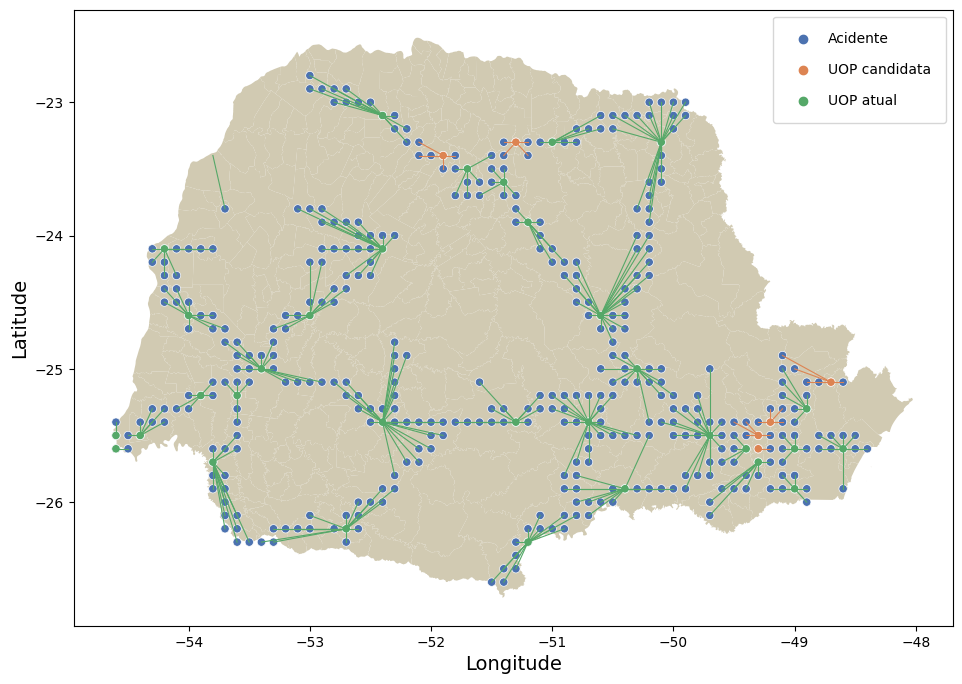

In [106]:
plot_solutions_map2(p=39, q=33)

In [ ]:
# df = df_quadrants[df_quadrants['name'].isin(uops_to_remove)].copy()
# df = df.merge(df_muns[['municipality', 'mun_name_orig']])
# x='longitude'
# y='latitude'
# xlab="Longitude"
# ylab="Latitude"
# figsize=(15,8)
# fontsize=14

# df['name_concat'] = df['name'] + " (" + df['mun_name_orig'] + ")"

# fig, ax = plt.subplots(figsize=figsize)
# SHAPE.plot(ax = ax, color = MAP_COLOR)
# p = sns.scatterplot(data=df, x=x, y=y, alpha=1, hue='name_concat', s=200)
# p.set_xlabel(xlab, fontsize=fontsize)
# p.set_ylabel(ylab, fontsize=fontsize)

# plt.legend(title=legend_name, title_fontsize=11, labelspacing=1.2, borderpad=1.1)
# plt.savefig('foo.png')   
# plt.show()

\begin{tabular}{rll}
\toprule
  &            UOP &                 Município \\
\midrule
1 & UOP03-DEL06-PR &              Alto Paraíso \\
2 & UOP04-DEL05-PR &             Foz do Iguaçu \\
3 & UOP04-DEL04-PR &                 Lindoeste \\
4 & UOP01-DEL05-PR & Santa Terezinha de Itaipu \\
\bottomrule
\end{tabular}



/var/folders/j1/pt3jwk353xqck3ls5h5twtn80000gn/T/ipykernel_43319/2442475438.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[['', 'UOP', 'Município']].to_latex(index=False, multirow=True))


In [91]:
# as UOPs a remover nunca foram escolhidas nas soluções livres
df_not_choosen = df_uops_all_range_q0[(df_uops_all_range_q0['pct_solutions'] == 0)]
df_not_choosen = df_not_choosen[df_not_choosen['is_uop'] == True].sort_values(by='name')
[uop for uop in df_not_choosen['name'] if uop in df['UOP']]

[]

In [92]:
range_p2 = [x for x in range(29, 50+1, 1)]
df_uops_by_sols_range2 = df_uops_by_sols[(df_uops_by_sols['p'].isin(range_p2)) & (df_uops_by_sols['q'] == 29)].copy()
df_uops_by_sols_range2.head()

,p,q,name
8916,29,29,UOP03-DEL07-PR
8917,29,29,UAP06-DEL01-PR
8918,29,29,UOP06-DEL01-PR
8919,29,29,UOP02-DEL01-PR
8920,29,29,UOP03-DEL09-PR


In [93]:
df_uops_by_sols_range2_agg = agg_and_merge_uops(df_uops_base, df_uops_by_sols_range2, len(range_p2), q=29)
uops_to_plot = df_uops_by_sols_range2_agg[(df_uops_by_sols_range2_agg['pct_solutions'] > 0) & (df_uops_by_sols_range2_agg['pct_solutions'] < 100)]['name']
uops_to_plot

26                 CURITIBA 03
27                  MARINGA 02
28                 CURITIBA 06
29              UOP02-DEL01-PR
30    CAMPINA GRANDE DO SUL 06
31                 CURITIBA 01
32     SAO JOSE DOS PINHAIS 06
33              UOP01-DEL05-PR
34              UOP04-DEL04-PR
35                   IBAITI 01
36                 BARRACAO 04
37     SAO JOSE DOS PINHAIS 03
38              UAP06-DEL01-PR
39             PONTA GROSSA 01
40                    CAMBE 01
41              CAMPO LARGO 04
42                   CANDOI 05
43                 LONDRINA 02
44                ARAPONGAS 03
45               GUARANIACU 02
46              UOP01-DEL01-PR
47                 CASCAVEL 04
48               MEDIANEIRA 01
49    CAMPINA GRANDE DO SUL 03
50        CORNELIO PROCOPIO 02
51                 MORRETES 02
52                  MARINGA 01
Name: name, dtype: object

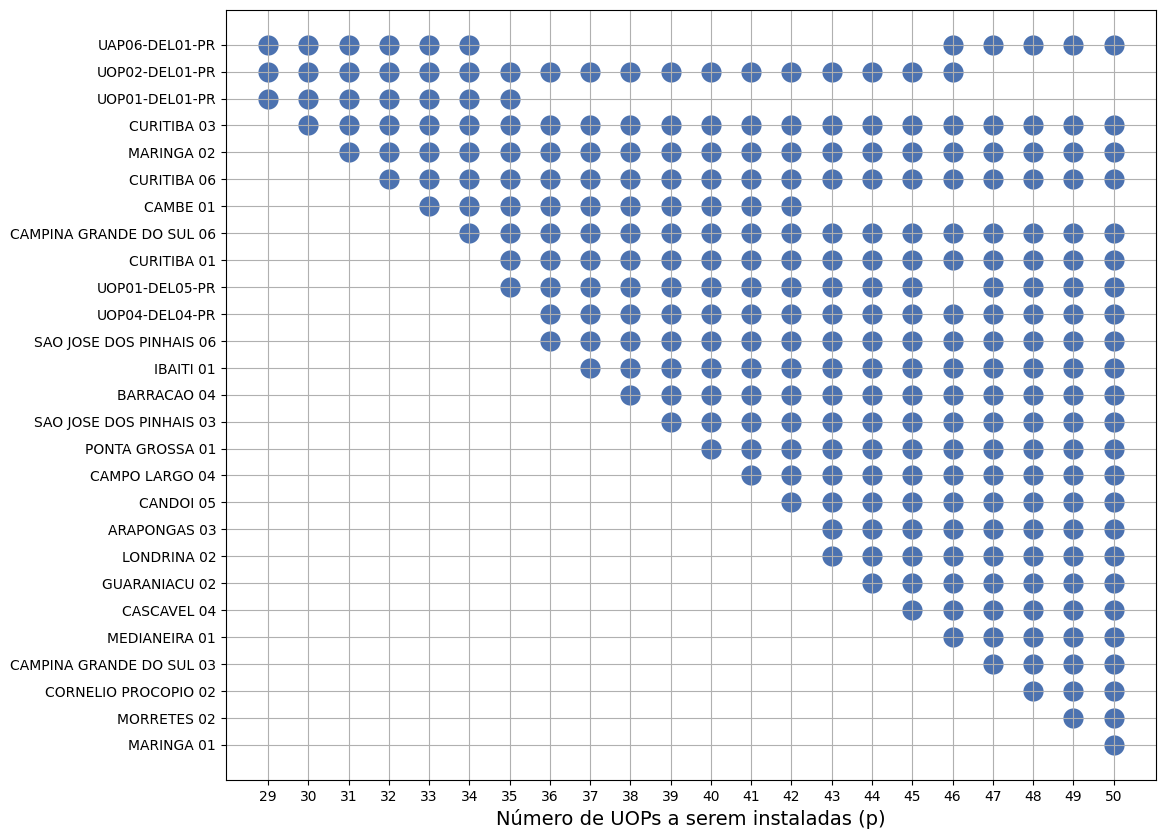

In [94]:
df_plot = df_uops_by_sols_range2[df_uops_by_sols_range2['name'].isin(uops_to_plot)]
plot_uops_by_sol(df_plot, range_p2, grid=True, figsize=(12,10), size=250)

In [95]:
# Desativar não significa demolir as UOPS, então as UOP01-DEL05-PR e UOP04-DEL04-PR podem ser reativadas sem custo.

In [96]:
custom_palette = [PALETTE.as_hex()[0], PALETTE.as_hex()[2]]
custom_palette


['#4c72b0', '#55a868']

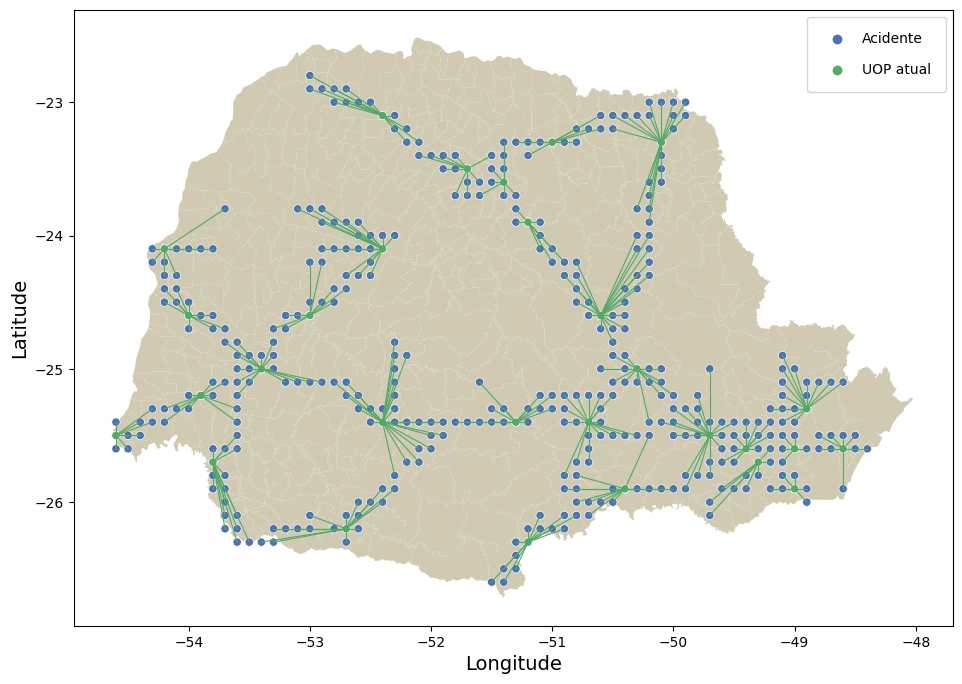

In [97]:
sns.set_palette(custom_palette)
plot_solutions_map2(p=29, q=29)
sns.set_palette('deep')

In [ ]:
# df_uops_atuais = df_quadrants[df_quadrants['is_uop'] == True]

# df_sol = get_solution_details(q=0, p=39)
# uops_modelo = df_sol[df_sol['is_median'] == True]['name']
# df_uops_modelo = df_quadrants[df_quadrants['name'].isin(uops_modelo)].copy()

# dist_matrix = get_distance_matrix(
#     lat_rows=df_uops_modelo['latitude'],
#     lon_rows=df_uops_modelo['longitude'],
#     lat_cols=df_uops_atuais['latitude'],
#     lon_cols=df_uops_atuais['longitude'],)

# lst_idx = []
# lst_dist = []
# idx_to_ignore = []
# for i in range(0, len(dist_matrix)):
#     row = dist_matrix[i]
#     min_dist = 999999999999
#     min_index = 999999999999
#     for j in range(0, len(row)):
#         if i != j: # and j not in idx_to_ignore:
#             if row[j] < min_dist:
#                 min_dist = row[j]
#                 min_index = list(row).index(row[j])
#     lst_idx.append(min_index)
#     lst_dist.append(min_dist)
#     idx_to_ignore.append(min_index)

# df_dists = pd.DataFrame({'idx_j': lst_idx, 'dist': lst_dist})
# df_dists['uop_i'] = [df_uops_modelo.iloc[u]['name'] for u in df_dists.index]
# df_dists['uop_j'] = [df_uops_atuais.iloc[u]['name'] for u in df_dists['idx_j'] if u < 999999]
# df_dists = df_dists.sort_values(by='dist').reset_index(drop=True)
# df_dists['cum_count'] = df_dists.groupby(['uop_j']).cumcount()+1

# Soluções restritas

In [ ]:
def calculate_dif_fo(df_irrestrita, df_restrita):
    fo_irrestrita = df_irrestrita['obj_function'].sum()
    fo_restrita = df_restrita['obj_function'].sum()
    pct_dif = (fo_restrita - fo_irrestrita)/fo_irrestrita*100

    logger.info(f"FO irrestrita: {fo_irrestrita}")
    logger.info(f"FO irrestrita: {fo_restrita}")
    logger.info(f"Variação: {round(pct_dif,2)}%")

In [ ]:
df_all_results.head()

In [ ]:
df_results_p = get_df_results(df_all_results, p=39)
df_results_p['obj_function_abs_pct_change'] = df_results_p['obj_function_abs_pct_change'].fillna(0)
df_results_p.head()

In [ ]:
plot_fo(
    df_results_p, 
    x_param="q", 
    xtick_min=0, 
    xtick_max=33, 
    invert_x=True, 
    pct_cutover=0.5, 
    p2_ytick_max=5, 
    xlabel="Número mínimo de UOPs atuais a serem mantidas (q)",
    arrow_txt="q = 15",
    arrow_xy=(15.2, 0.18),
    arrow_txt_xy=(24, 0.3),)

In [ ]:
df_sol_p39_q15 = get_solution_details(p=39, q=15)
df_sol_p39_q0 = get_solution_details(p=39, q=0)

In [ ]:
calculate_dif_fo(df_irrestrita=df_sol_p39_q0, df_restrita=df_sol_p39_q15)

In [ ]:
(383230 - 378908)/378908*100